# Vol. 2.1. Machine learning-based prediction of blast movement via Quantile regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Raw BMM spreadsheet cleaning

Now that we are dealing with an almost-ready-to-use file, we just need to do some more cleaning. Let's take a look how the new file looks.

In [2]:
df_raw = pd.read_excel('obtained_data.xlsx', usecols=lambda column: column != 'Unnamed: 0')
df_raw.iloc[:,3:].head()

elev  bmm_elev expl_type   confined   bp_h  inst_depth  inst_h  \
0  474.667   470.967      ANFO  free face  4.667         3.7   0.967   
1  474.667   472.967      ANFO  free face  4.667         1.7   2.967   
2  474.601   470.901      ANFO  free face  4.601         3.7   0.901   
3  474.601   472.901      ANFO  free face  4.601         1.7   2.901   
4  475.126   471.426      ANFO  free face  5.126         3.7   1.426   

   det_depth     det_h     act_dir  ...     bp_pf  ideal_dir  \
0   4.282504  1.061496  161.867800  ...  0.318216        NaN   
1   2.033786  3.229214  187.461599  ...  0.318216        NaN   
2   5.423375  0.376625  151.617502  ...  0.318216        NaN   
3   2.239060  3.802940  188.005486  ...  0.318216        NaN   
4   4.148262  1.383738  228.806465  ...  0.318216        NaN   

   voronoi_rock_vol  loc_dh_len loc_expl_len  loc_stem_len  loc_expl_mass  \
0               NaN         NaN          NaN           NaN            NaN   
1               NaN         NaN          NaN           NaN            NaN   
2               NaN         NaN          NaN           NaN            NaN   
3               NaN         NaN          NaN           NaN            NaN   
4               NaN         NaN          NaN           NaN            NaN   

   booster  dist_first  loc_to_first_dir  
0      NaN         NaN               NaN  
1      NaN         NaN               NaN  
2      NaN         NaN               NaN  
3      NaN         NaN               NaN  
4      NaN         NaN               NaN  

[5 rows x 29 columns]

In [3]:
df_raw.shape

(1305, 32)

So far, the file has loaded all the necessary data. Now we have to drop the rows with missing information. This is due to having some observations which did not match with the blast design data. I would say that imputing missing blast design features is not be a good idea.

In [4]:
df_raw = df_raw.dropna().reset_index(drop=True)

Once more, we load the gas products dictionary for both explosive types.

In [5]:
expl_gas_prod_dict = {
    'ANFO': 988,
    'Riogel': 933
}

Some additional features were engineered and introduced as columns to the dataframe including:
- Post-blast panel height (m)
- Horizontal movement deviation angle (°) - Angle deviating from ideal movement direction
- Horizontal movement towards free face (m) - Horizontal movement vector major component, following the ideal movement direction
- Horizontal movement deviation (m) - Horizontal movement vector minor component, orthogonal to the ideal movement direction
- Local powder factor (kg/m³) - Ratio between of explosives mass and Voronoi rockmass in proximity to monitoring location
- Local gas products factor (l/m³) - Ratio between volume of explosive gas products and Voronoi rockmass in proximity to monitoring location
- Total ammount of gas products in proximity to monitoring location (l)
- Distance towards free face (m) - Distance to first row drillholes

In [6]:
df_raw['bp_post_h'] = df_raw['det_h'] + df_raw['det_depth']

In [7]:
df_raw['h_dev_angle'] = np.abs(df_raw['ideal_dir'] - df_raw['act_dir'])
df_raw['h_dev_angle'] = df_raw.apply(
    lambda row: -row['h_dev_angle'] if (0 <= row['loc_to_first_dir'] < 90 or 180 <= row['loc_to_first_dir'] < 270) 
    else row['h_dev_angle'], 
    axis=1
)

In [8]:
df_raw['m_h_ff'] = np.cos(np.deg2rad(df_raw['h_dev_angle'] )) * df_raw['m_h']
df_raw['m_h_dev'] = np.sin(np.deg2rad(df_raw['h_dev_angle'] )) * df_raw['m_h']

In [9]:
df_raw['loc_pf'] = df_raw['loc_expl_mass'] / df_raw['voronoi_rock_vol']
df_raw['loc_gpf'] = df_raw['loc_pf'] * df_raw['expl_type'].map(expl_gas_prod_dict)
df_raw['loc_gp_vol'] = df_raw['loc_expl_mass'] * df_raw['expl_type'].map(expl_gas_prod_dict)

In [10]:
df_raw['dist_ff'] = np.abs(df_raw['dist_first'] * np.cos(np.radians(df_raw['loc_to_first_dir'])))

In [11]:
df_raw.iloc[:,3:].head()

elev  bmm_elev expl_type   confined   bp_h  inst_depth  inst_h  \
0  474.938   471.138      ANFO  free face  4.938         3.8   1.138   
1  474.938   473.238      ANFO  free face  4.938         1.7   3.238   
2  475.110   471.510      ANFO  free face  5.110         3.6   1.510   
3  475.110   473.410      ANFO  free face  5.110         1.7   3.410   
4  474.824   471.224      ANFO  free face  4.824         3.6   1.224   

   det_depth     det_h     act_dir  ...  dist_first  loc_to_first_dir  \
0   4.626556  0.677444  141.107178  ...   33.382023        -81.043613   
1   1.983379  3.466621  146.309932  ...   33.382023        -81.043613   
2   4.491994  1.098006  136.568421  ...   33.619441        -45.097612   
3   2.319462  3.435538  143.513696  ...   33.619441        -45.097612   
4   3.974748  1.129252  136.533220  ...   49.921806        -31.932997   

   bp_post_h  h_dev_angle    m_h_ff   m_h_dev    loc_pf     loc_gpf  \
0      5.304     0.613786  1.036787  0.011107  0.357001  352.717385   
1      5.450     4.588968  1.484319  0.119138  0.357001  352.717385   
2      5.590     6.737284  1.180178  0.139418  0.353972  349.723846   
3      5.755     0.207990  1.643026  0.005964  0.353972  349.723846   
4      5.104    22.063049  1.494023  0.605538  0.352243  348.016277   

    loc_gp_vol  dist_ff  
0  109053.0688    5.197  
1  109053.0688    5.197  
2  130457.8912   23.732  
3  130457.8912   23.732  
4  122536.8976   42.367  

[5 rows x 37 columns]

In [12]:
df_raw.shape

(1187, 40)

ALthoug missing values were dropped and no imputations were meade, we still have lots of data to analyze. 

In [13]:
df_raw.columns

Index(['bp_id', 'east', 'north', 'elev', 'bmm_elev', 'expl_type', 'confined',
       'bp_h', 'inst_depth', 'inst_h', 'det_depth', 'det_h', 'act_dir',
       'act_incl', 'm_3d', 'm_h', 'm_v', 'date', 'bp_drill_m', 'bp_vol',
       'bp_mass', 'bp_expl_mass', 'bp_pf', 'ideal_dir', 'voronoi_rock_vol',
       'loc_dh_len', 'loc_expl_len', 'loc_stem_len', 'loc_expl_mass',
       'booster', 'dist_first', 'loc_to_first_dir', 'bp_post_h', 'h_dev_angle',
       'm_h_ff', 'm_h_dev', 'loc_pf', 'loc_gpf', 'loc_gp_vol', 'dist_ff'],
      dtype='object')

Additional conditions for outliers were adopted for this analysis, which refer not only to movement results, but also to engineering conditions.

They include the following criteria:
- Blastes which do not employ boosters are disregarde, as no blast can occur without a booster.
- Installation height below 0.1 m are considered outliers
- Distances from the free face lower than 5 m and above 110 m are considered outliers as they have singular observations (this may have to be relaxed in the future when additional data is collected)
- Horizontal movement deviation angle is constrained between -90° and 90° as backwards movement is considered highly improbable.
-  Horizontal movement above 3.5 m is considered to be highly irregular and rare and hence samples are deemed outlers
-  Vertical movement vectors with values below -1 m and above 2 m are considered to be highly irregular and rare and hence samples are deemed outlers
-  Horizontal movement deviation vectors with values below -1 m and above 1.5 m are considered to be highly irregular and rare and hence samples are deemed outlers

In [14]:
conditions = (df_raw['booster'] > 0.400) \
            & (df_raw['inst_h'] > 0.1) \
            & (df_raw['dist_ff'] >= 5) & (df_raw['dist_ff'] <= 110) \
            & (df_raw['loc_gpf'] <= 700) \
            & (df_raw['h_dev_angle'] <= 90) & (df_raw['h_dev_angle'] >= -90)\
            & (df_raw['m_h_ff'] >= 0) & (df_raw['m_h_ff'] <= 3.5) \
            & (df_raw['m_v'] >= -1 ) & (df_raw['m_v'] <= 2 ) \
            & (df_raw['m_h_dev'] >= -1) & (df_raw['m_h_dev'] <= 1.5)

df = df_raw[conditions].copy()
df.iloc[:,3:].head()

elev  bmm_elev expl_type   confined   bp_h  inst_depth  inst_h  \
0  474.938   471.138      ANFO  free face  4.938         3.8   1.138   
1  474.938   473.238      ANFO  free face  4.938         1.7   3.238   
2  475.110   471.510      ANFO  free face  5.110         3.6   1.510   
3  475.110   473.410      ANFO  free face  5.110         1.7   3.410   
4  474.824   471.224      ANFO  free face  4.824         3.6   1.224   

   det_depth     det_h     act_dir  ...  dist_first  loc_to_first_dir  \
0   4.626556  0.677444  141.107178  ...   33.382023        -81.043613   
1   1.983379  3.466621  146.309932  ...   33.382023        -81.043613   
2   4.491994  1.098006  136.568421  ...   33.619441        -45.097612   
3   2.319462  3.435538  143.513696  ...   33.619441        -45.097612   
4   3.974748  1.129252  136.533220  ...   49.921806        -31.932997   

   bp_post_h  h_dev_angle    m_h_ff   m_h_dev    loc_pf     loc_gpf  \
0      5.304     0.613786  1.036787  0.011107  0.357001  352.717385   
1      5.450     4.588968  1.484319  0.119138  0.357001  352.717385   
2      5.590     6.737284  1.180178  0.139418  0.353972  349.723846   
3      5.755     0.207990  1.643026  0.005964  0.353972  349.723846   
4      5.104    22.063049  1.494023  0.605538  0.352243  348.016277   

    loc_gp_vol  dist_ff  
0  109053.0688    5.197  
1  109053.0688    5.197  
2  130457.8912   23.732  
3  130457.8912   23.732  
4  122536.8976   42.367  

[5 rows x 37 columns]

In [15]:
df.shape

(1106, 40)

Only 81 observations were dropped, which still leaves us with lots of data to analyze and use for predictive modelling.

In [16]:
df.iloc[:,3:].head()

elev  bmm_elev expl_type   confined   bp_h  inst_depth  inst_h  \
0  474.938   471.138      ANFO  free face  4.938         3.8   1.138   
1  474.938   473.238      ANFO  free face  4.938         1.7   3.238   
2  475.110   471.510      ANFO  free face  5.110         3.6   1.510   
3  475.110   473.410      ANFO  free face  5.110         1.7   3.410   
4  474.824   471.224      ANFO  free face  4.824         3.6   1.224   

   det_depth     det_h     act_dir  ...  dist_first  loc_to_first_dir  \
0   4.626556  0.677444  141.107178  ...   33.382023        -81.043613   
1   1.983379  3.466621  146.309932  ...   33.382023        -81.043613   
2   4.491994  1.098006  136.568421  ...   33.619441        -45.097612   
3   2.319462  3.435538  143.513696  ...   33.619441        -45.097612   
4   3.974748  1.129252  136.533220  ...   49.921806        -31.932997   

   bp_post_h  h_dev_angle    m_h_ff   m_h_dev    loc_pf     loc_gpf  \
0      5.304     0.613786  1.036787  0.011107  0.357001  352.717385   
1      5.450     4.588968  1.484319  0.119138  0.357001  352.717385   
2      5.590     6.737284  1.180178  0.139418  0.353972  349.723846   
3      5.755     0.207990  1.643026  0.005964  0.353972  349.723846   
4      5.104    22.063049  1.494023  0.605538  0.352243  348.016277   

    loc_gp_vol  dist_ff  
0  109053.0688    5.197  
1  109053.0688    5.197  
2  130457.8912   23.732  
3  130457.8912   23.732  
4  122536.8976   42.367  

[5 rows x 37 columns]

Everything seems in order. Let's save it just in case!

In [17]:
df.to_excel('new_cleaned_data.xlsx')

## Traning and testing quantile regression models

As the training and testing of multiple models can be a bit tedious, a few functions were defined to make the process qikcer and easily adjustable.

### Defining key analysis and plotting functions

In [18]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score, learning_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_halving_search_cv, enable_halving_search_cv
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore", message="The total space of parameters .* smaller than n_iter=")

As the osbervations are highly scattered, a binned scatter plot, based on the average and different quantile values is created to make feature selection easier.

In [19]:
def plot_binned_scatterplots(df, feature, target, bin_list, tau=0.5):
    """
    Plots scatterplots with binned data for a range of bin configurations, side by side.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    feature (str): The name of the feature column.
    target (str): The name of the target column.
    bin_list (list): List of integers defining the number of bins for each plot.
    tau (float): Quantile level (default is 0.5 for median).
    """
    n_plots = len(bin_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4), sharey=True)
    
    if n_plots == 1:  # If only one plot is requested
        axes = [axes]
    
    for ax, bins in zip(axes, bin_list):
        # Define bin edges
        bin_edges = np.linspace(df[feature].min(), df[feature].max(), bins + 1)
        labels = [f"{round(bin_edges[i], 2)}-{round(bin_edges[i + 1], 2)}" for i in range(len(bin_edges) - 1)]

        # Bin the feature values
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=bin_edges, labels=labels, include_lowest=True)

        # Calculate bin centers for all bins
        bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

        # Group by bins and compute statistics
        grouped = df.groupby(f'{feature}_bin', observed=True)
        mean_y = grouped[target].mean()
        percentile_y = grouped[target].quantile(tau)

        # Filter only valid bins (those that contain data)
        valid_bins = mean_y.index[~mean_y.isna()]
        valid_bin_centers = [bin_centers[i] for i in range(len(labels)) if labels[i] in valid_bins]

        # Drop NaN values to align lengths
        mean_y = mean_y.dropna()
        percentile_y = percentile_y.dropna()

        # Plot
        ax.scatter(df[feature], df[target], alpha=0.6, label='Data points', color='gray', s=25)
        ax.scatter(valid_bin_centers, mean_y.values, color='red', label='Mean', s=50, zorder=5)
        ax.scatter(valid_bin_centers, percentile_y.values, color='blue', label=f'P {tau*100:.1f}', s=50, zorder=5)
        ax.set_title(f'Scatter Plot with {bins} Bins')
        ax.set_xlabel(feature)
        ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--', alpha=0.7)
        ax.grid(alpha=0.3)

    axes[0].set_ylabel(target)
    axes[-1].legend(fontsize=12)
    plt.tight_layout()
    plt.show()


As a quantile regression is the choice of modelling framework, hence, the *quantile loss* function is defined as way to measure loss.

In [20]:
def quantile_loss_ml(y_true, y_pred, quantile=0.5):
    diff = y_true - y_pred
    return np.mean(np.maximum(quantile * diff, (1 - quantile) * -diff))

This functions provides a way to plot the learning curve for an arbitrary model using k-fold cross validation.

In [21]:
def plot_ml_learning_curve(name, model, X_train_scaled, y_train, quantile=0.5, k_folds=5):
    '''
    Validate model through 5-fold cross validation and plot learning curve
    '''    
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring=quantile_loss_scorer)
    
    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_scaled,  # Features
        y_train,  # Target
        cv=kf,
        scoring=quantile_loss_scorer,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    # Compute mean and standard deviation of scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.figure(figsize=(8, 3))
    plt.title(f"Learning Curve for {name} (Q={quantile:.2f})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Quantile Loss")
    plt.grid()
    
    # Plot mean and std deviation for training and test scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()
    
    # Print cross-validation results
    cv_scores_mean = -np.mean(cv_scores)
    cv_scores_std = np.std(cv_scores)
    
    print(f"Cross-validated quantile loss: {cv_scores_mean:.4f} ± {cv_scores_std:.4f}")

In [22]:
def test_ml_model(model, X_train, y_train, X_test, y_test, quantile):
    y_pred_train = model.predict(X_train)
    quantile_loss_train = quantile_loss_ml(y_train, y_pred_train, quantile)
    
    y_pred_test = model.predict(X_test)
    quantile_loss_test = quantile_loss_ml(y_test, y_pred_test, quantile)
    
    print(f"Quantile Loss on Train Set: {quantile_loss_train:.4f}")
    print(f"Quantile Loss on Test Set: {quantile_loss_test:.4f}")
    print()
    print()
    
    return y_pred_test

In [23]:
def plot_predict_hist(y_test, predictions, target):
    all_predictions = np.concatenate(list(predictions.values()))
    
    plt.figure(figsize=(7, 3))
    plt.hist(all_predictions, bins=25, alpha=0.5, edgecolor='black', label='Predicted', density=True)
    plt.hist(y_test, bins=25, alpha=0.5, edgecolor='black', label='Actual', density=True)
    plt.title('Histogram of Predicted Results for Quantiles')
    plt.xlabel(target)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [24]:
def plot_predict_scatter(X_test, y_test, predictions, quantiles, predictors_list, target):
    """
    Plots scatter plots of predictions and true values against predictors.
    """
    all_predictions = np.concatenate(list(predictions.values()))  # Combine predictions for all quantiles
    
    # Handle cases with a single predictor
    if X_test.shape[1] == 1:
        predictor_values = np.tile(X_test.values.flatten(), len(quantiles))
        
        plt.figure(figsize=(7, 3))
        plt.scatter(predictor_values, all_predictions, color='tab:blue', alpha=0.2, s=5, label='Predictions')
        plt.scatter(X_test.values.flatten(), y_test, color='black', alpha=0.5, s=10, label='True Values')
        plt.xlabel(predictors_list[0])
        plt.ylabel(target)
        plt.legend()
        plt.title(f'Scatter Plot for {predictors_list[0]}')
    
    # Handle cases with multiple predictors
    else:
        num_predictors = len(predictors_list)
        fig, axes = plt.subplots(1, num_predictors, figsize=(5 * num_predictors, 3))
        
        if num_predictors == 1:  # Single subplot for one predictor
            axes = [axes]
        
        for i, ax in enumerate(axes):
            predictor_values = np.tile(X_test.values[:, i], len(quantiles))
            ax.scatter(predictor_values, all_predictions, color='tab:blue', alpha=0.2, s=5, label='Predictions')
            ax.scatter(X_test.values[:, i], y_test, color='black', alpha=0.5, s=10, label='True Values')
            ax.set_xlabel(predictors_list[i])
            ax.set_ylabel(target)
            ax.legend()
            ax.set_title(f'Scatter Plot for {predictors_list[i]}')
        
        plt.tight_layout()

    plt.show()

### Defining key models

For the purpose a 5-fold cross validation strategy was used for establishing best hyperparameters of three models:
- Linear model
- Gradient boosted trees (GBT)
- Histogram-based gradient boosted trees (for the sake of speeding up the work and approximating the rsults of GBTs)

In [25]:
from sklearn.linear_model import QuantileRegressor

def train_cv_lqr(X_train, y_train, quantile=0.5,  cv=5):
    """
    Trains a Quantile Linear Regression model using Halving Random Search CV with NumPy arrays.
    """        
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    # Define the Quantile Regressor model
    quantile_reg = QuantileRegressor(quantile=quantile, solver='highs')
    
    # Define the parameter grid
    param_grid = {
        'alpha': np.logspace(-10, 1, 100),        # Regularization strength
        'solver': ['highs'],
        # 'fit_intercept': [True]
    }
    
    # Perform Halving Random Search
    quantile_halving_random_search = HalvingRandomSearchCV(
        estimator=quantile_reg,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the search
    quantile_halving_random_search.fit(X_train, y_train)

    return quantile_halving_random_search

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

def train_cv_gt_qr(X_train, y_train, quantile=0.5, cv=5):
    """
    Trains a Decision Tree Ensemble (Gradient Boosting) for Quantile Regression using Halving Random Search CV.
    """    
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)

    # Define the Gradient Boosting Regressor for Quantile Regression
    gbr = GradientBoostingRegressor(loss='quantile', alpha=quantile)

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100],         # Number of boosting stages
        'max_depth': [4],                # Maximum depth of trees
        'learning_rate': [0.001, 0.01, 0.1, 0.2],     # Shrinkage rate
        'min_samples_split': [2, 5, 10],       
        'min_samples_leaf': [1, 3, 5],         
        'subsample': [0.6, 0.8, 1.0]           
    }

    # Perform Halving Random Search
    halving_search = HalvingRandomSearchCV(
        estimator=gbr,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1
    )

    # Fit the search to the data
    halving_search.fit(X_train, y_train)

    return halving_search

In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

def train_cv_hbgt_qr(X_train, y_train, quantile=0.5, cv=5):
    """
    Trains a Histogram-based Gradient Boosting Regressor using quantile regression
    with Halving Random Search CV.
    """   
    quantile_loss_scorer = make_scorer(quantile_loss_ml, greater_is_better=False, quantile=quantile)
    
    # Define the HistGradientBoostingRegressor with quantile loss
    hist_gbr = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
    
    # Define the parameter grid
    param_grid = {
        'max_iter': [50, 100],
        'learning_rate': np.logspace(-5, 0, 10),
        'max_depth': [5, 10],
        'max_bins': [5, 15, 20],
        'l2_regularization': np.logspace(-4, 1, 5),
    }
    
    # Perform Halving Random Search
    halving_random_search = HalvingRandomSearchCV(
        estimator=hist_gbr,
        param_distributions=param_grid,
        factor=3,
        cv=cv,
        scoring=quantile_loss_scorer,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the search
    halving_random_search.fit(X_train, y_train)
    
    return halving_random_search

In [28]:
def build_nn_model(X_train, y_train, quantile):
    n_features = X_train.shape[1]
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(2, activation='tanh'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss=lambda y, y_pred: quantile_loss_dl(y, y_pred, quantile))
    return model

In [29]:
def store_ml_model_data(model_name, X_train_scaled, y_train, X_test_scaled, y_test, k_folds, quantiles):
    models = {}
    predictions = {}
    
    for quantile in quantiles:
        quantile = np.round(quantile, 2)
        if model_name == 'Linear model':
            model = train_cv_lqr(X_train_scaled, y_train, quantile)
        elif model_name == 'Gradient trees':
            model = train_cv_gt_qr(X_train_scaled, y_train, quantile)
        elif model_name == 'Histogram-based gradient trees':
            model = train_cv_hbgt_qr(X_train_scaled, y_train, quantile)
        
        best_model = model.best_estimator_
        y_pred_quantile = best_model.predict(X_test_scaled)
        plot_ml_learning_curve(model_name, best_model, X_train_scaled, y_train, quantile, k_folds)
        full_model = best_model.fit(X_train_scaled, y_train)
    
        y_pred_test = test_ml_model(full_model, X_train_scaled, y_train, X_test_scaled, y_test, quantile)
        
        models[quantile] = model
        predictions[quantile] = y_pred_test

    return models, predictions

In [30]:
def store_dl_model_data(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, quantiles, epochs=35, batch_size=64):
    models = {}
    predictions = {}
    
    for quantile in quantiles:
        quantile = np.round(quantile, 2)
        model = build_nn_model(X_train_scaled, y_train, quantile)
        history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val), verbose=0)
        plot_dl_learning_curve(history, quantile)
        
        y_pred_test = test_dl_model(model, X_test_scaled, y_test, quantile)
        
        models[quantile] = model
        predictions[quantile] = y_pred_test

    return models, predictions

### Aim and objectives

The aim of the study is to establish all 4 blast movement parameters: 
- Horizontal movement towards free face (m)
- Horizontal movement deviation vector (m)
- Vertical movement vector (m)
- Blast panel height post-blasting (m)

  
In order to achieve this result, several key objectives need to be solved:
1. Evaluate which features affect the 4 parameters of blast movement
2. Evaluate the predictive perofrmance of different quantile regression models
3. Deploy and test models for conditional simulation of blast movement

In [31]:
targets = ['m_h_ff', 'm_v', 'm_h_dev', 'det_depth']

In [32]:
quantiles = np.arange(0.1, 1.0, 0.1)

### Horizontal movement prediction

#### Feature selection

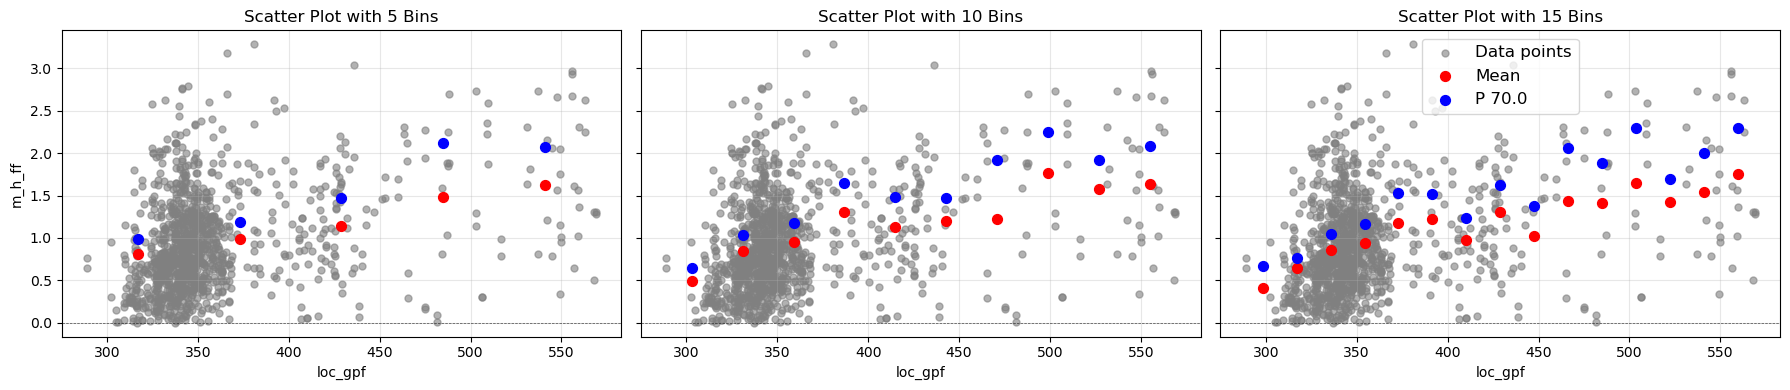

In [33]:
plot_binned_scatterplots(df, 'loc_gpf', 'm_h_ff', bin_list=[5, 10, 15], tau=0.7)

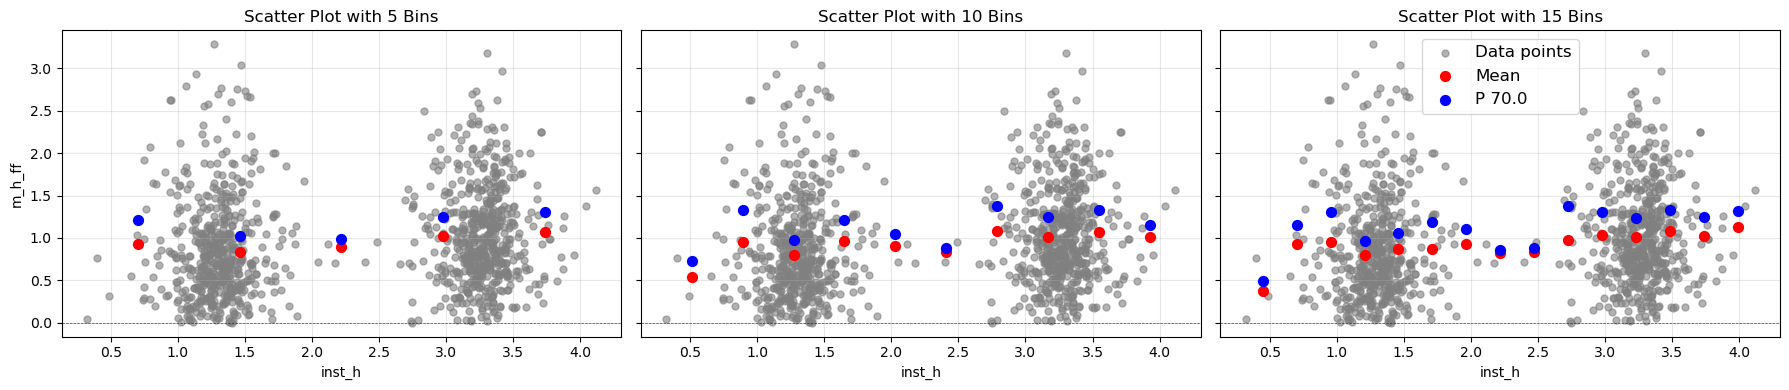

In [34]:
plot_binned_scatterplots(df, 'inst_h', 'm_h_ff', bin_list=[5, 10, 15], tau=0.7)

#### Training preparation

In [35]:
predictors_m_h_ff = [
    'inst_h',
    'loc_gpf',
]

In [36]:
k_folds = 5
partition = 0.2

In [37]:
train_m_h_ff, test_m_h_ff = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_h_ff, y_train_m_h_ff = train_m_h_ff[predictors_m_h_ff], train_m_h_ff[targets[0]]
X_test_m_h_ff, y_test_m_h_ff = test_m_h_ff[predictors_m_h_ff], test_m_h_ff[targets[0]]

# Initialize QuantileTransformer for the target column
x_scaler_m_h_ff = StandardScaler()

# Scale X (features)
X_train_scaled_m_h_ff = x_scaler_m_h_ff.fit_transform(X_train_m_h_ff)
X_test_scaled_m_h_ff = x_scaler_m_h_ff.transform(X_test_m_h_ff)

#### Linear quantile regression

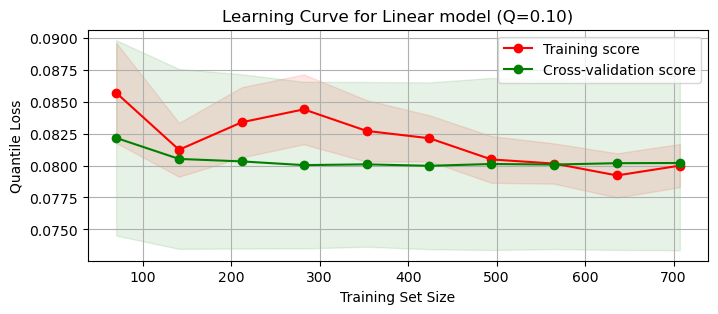

Cross-validated quantile loss: 0.0802 ± 0.0068
Quantile Loss on Train Set: 0.0800
Quantile Loss on Test Set: 0.0811




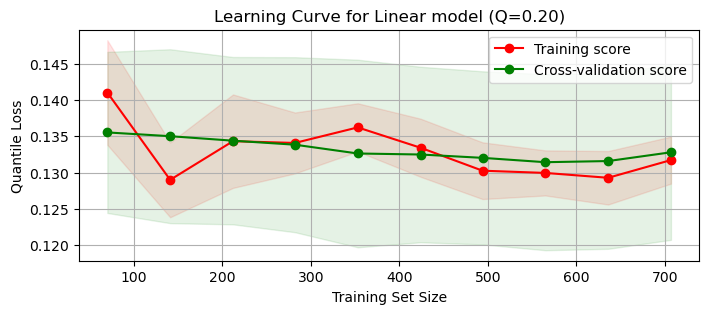

Cross-validated quantile loss: 0.1328 ± 0.0121
Quantile Loss on Train Set: 0.1320
Quantile Loss on Test Set: 0.1301




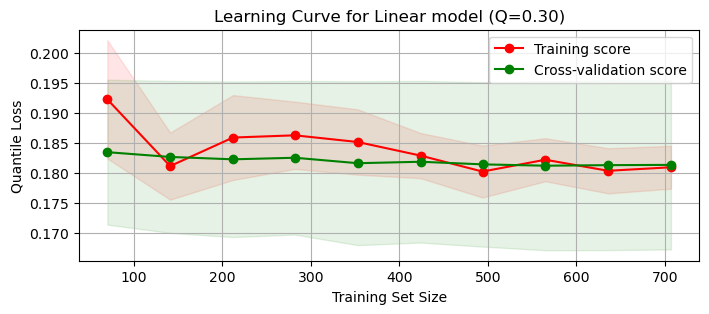

Cross-validated quantile loss: 0.1814 ± 0.0141
Quantile Loss on Train Set: 0.1810
Quantile Loss on Test Set: 0.1847




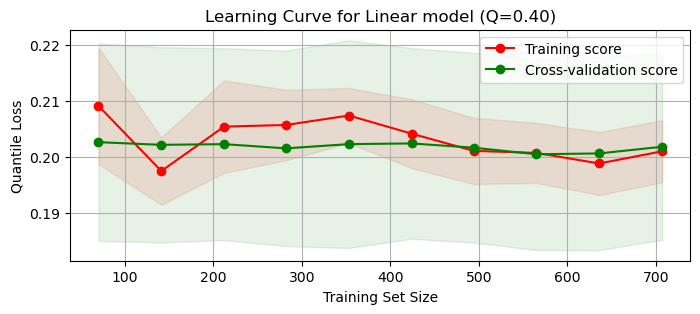

Cross-validated quantile loss: 0.2018 ± 0.0166
Quantile Loss on Train Set: 0.2014
Quantile Loss on Test Set: 0.2013




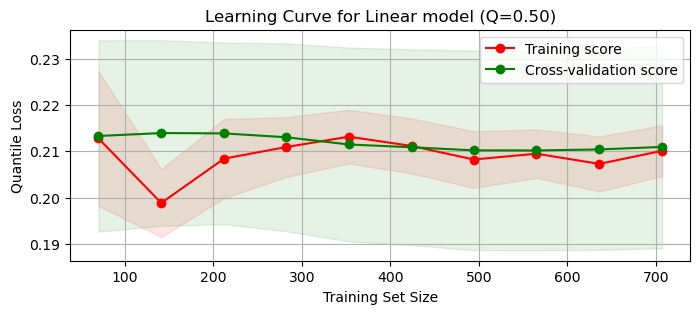

Cross-validated quantile loss: 0.2110 ± 0.0219
Quantile Loss on Train Set: 0.2101
Quantile Loss on Test Set: 0.2062




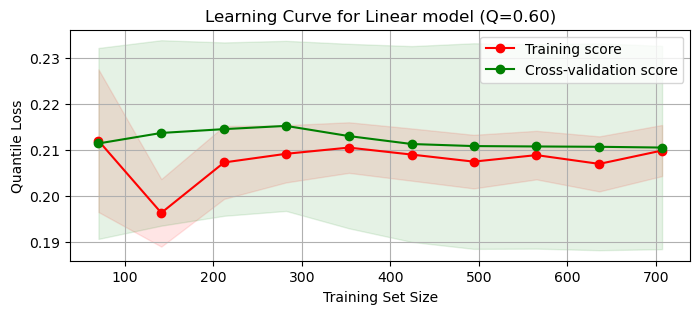

Cross-validated quantile loss: 0.2105 ± 0.0220
Quantile Loss on Train Set: 0.2099
Quantile Loss on Test Set: 0.2079




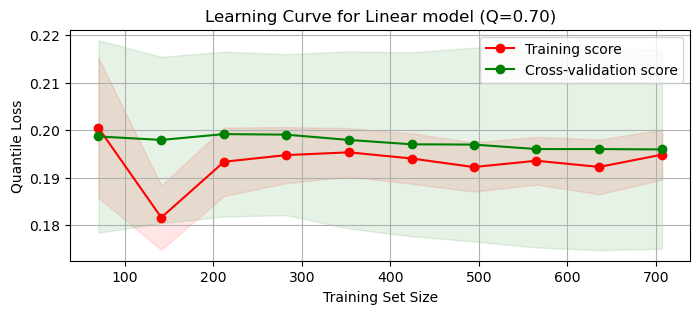

Cross-validated quantile loss: 0.1960 ± 0.0209
Quantile Loss on Train Set: 0.1950
Quantile Loss on Test Set: 0.1944




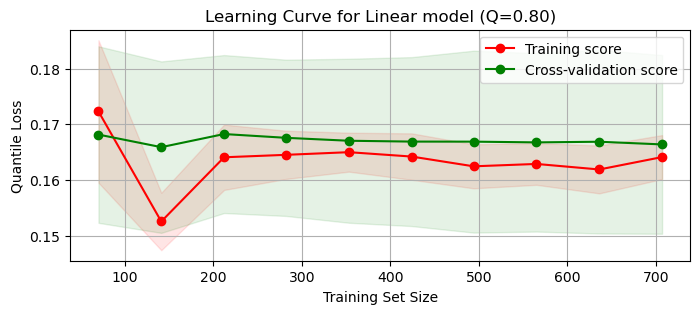

Cross-validated quantile loss: 0.1664 ± 0.0160
Quantile Loss on Train Set: 0.1644
Quantile Loss on Test Set: 0.1675




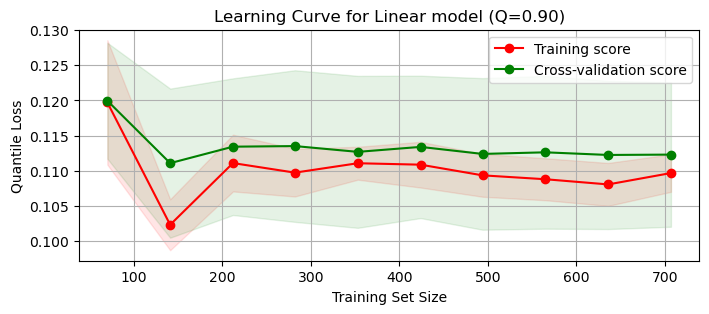

Cross-validated quantile loss: 0.1123 ± 0.0102
Quantile Loss on Train Set: 0.1100
Quantile Loss on Test Set: 0.1155




In [38]:
start_t = time.time()
models_lqr_m_h_ff, predictions_lqr_m_h_ff = store_ml_model_data('Linear model', 
                                                                X_train_scaled_m_h_ff, 
                                                                y_train_m_h_ff, 
                                                                X_test_scaled_m_h_ff, 
                                                                y_test_m_h_ff, 
                                                                k_folds, 
                                                                quantiles)
finish_t = time.time()

In [39]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 33.83s


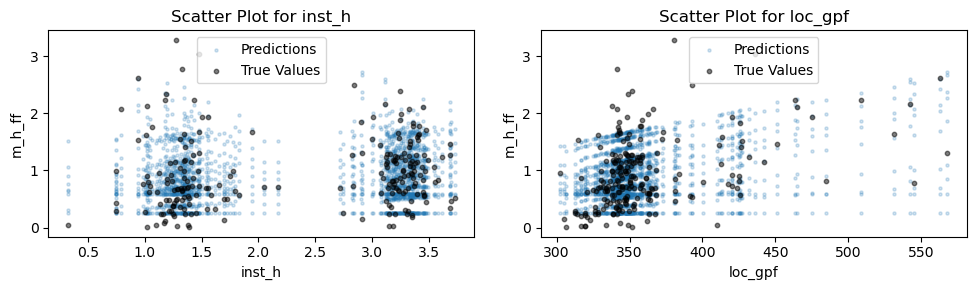

In [40]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_lqr_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

#### Gradient trees quantile regression

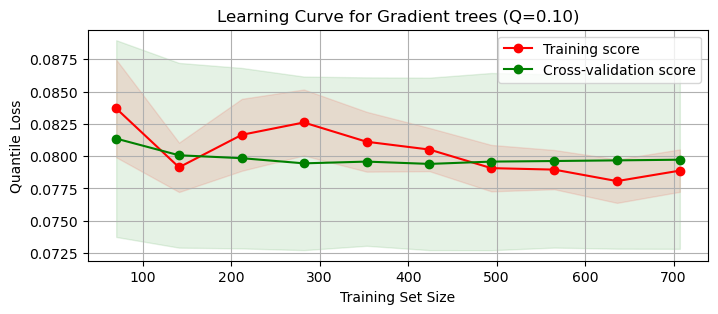

Cross-validated quantile loss: 0.0797 ± 0.0069
Quantile Loss on Train Set: 0.0790
Quantile Loss on Test Set: 0.0800




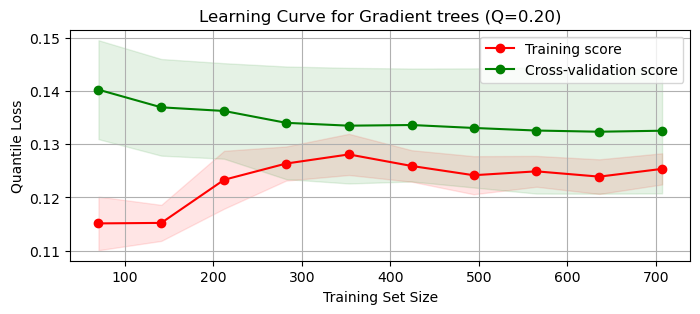

Cross-validated quantile loss: 0.1324 ± 0.0120
Quantile Loss on Train Set: 0.1257
Quantile Loss on Test Set: 0.1291




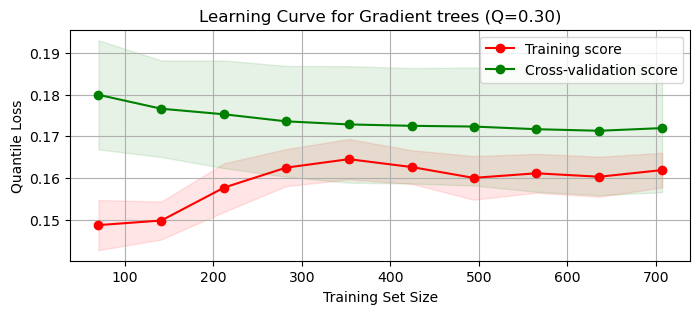

Cross-validated quantile loss: 0.1719 ± 0.0151
Quantile Loss on Train Set: 0.1629
Quantile Loss on Test Set: 0.1695




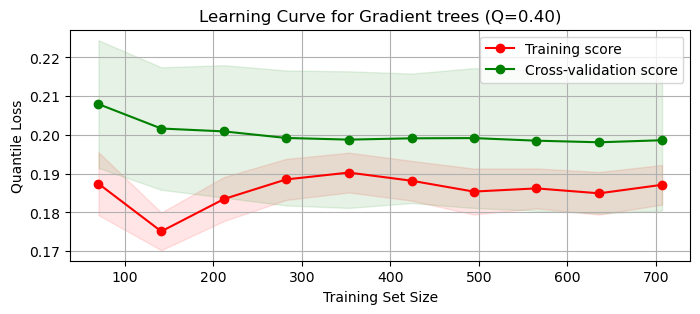

Cross-validated quantile loss: 0.1986 ± 0.0186
Quantile Loss on Train Set: 0.1877
Quantile Loss on Test Set: 0.1951




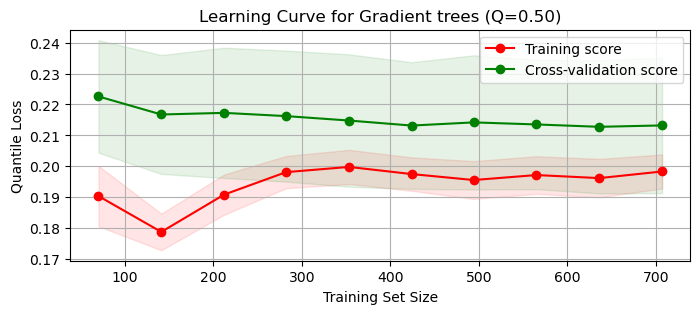

Cross-validated quantile loss: 0.2131 ± 0.0218
Quantile Loss on Train Set: 0.1992
Quantile Loss on Test Set: 0.2120




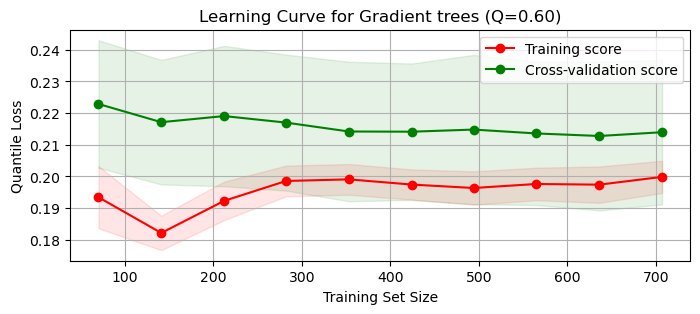

Cross-validated quantile loss: 0.2138 ± 0.0226
Quantile Loss on Train Set: 0.2006
Quantile Loss on Test Set: 0.2139




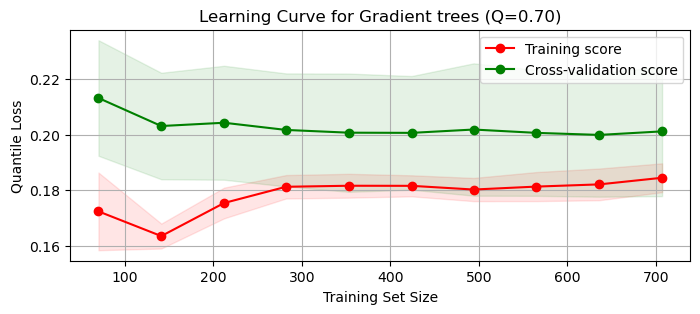

Cross-validated quantile loss: 0.2010 ± 0.0230
Quantile Loss on Train Set: 0.1860
Quantile Loss on Test Set: 0.1987




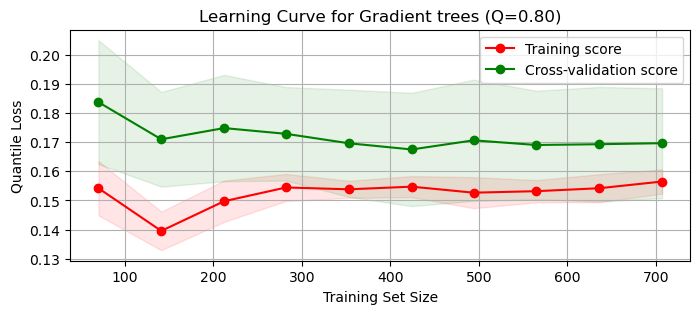

Cross-validated quantile loss: 0.1695 ± 0.0188
Quantile Loss on Train Set: 0.1600
Quantile Loss on Test Set: 0.1761




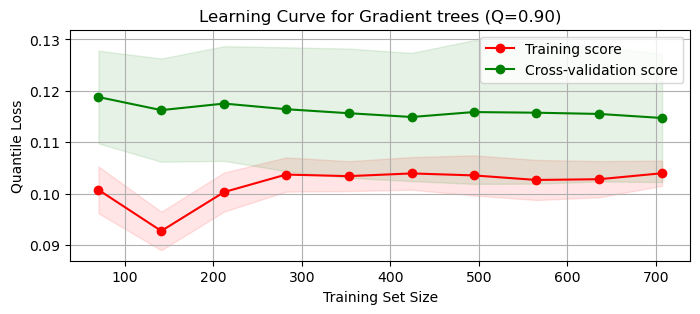

Cross-validated quantile loss: 0.1146 ± 0.0128
Quantile Loss on Train Set: 0.1050
Quantile Loss on Test Set: 0.1198




In [41]:
start_t = time.time()
models_gt_m_h_ff, predictions_gt_m_h_ff = store_ml_model_data('Gradient trees', 
                                                              X_train_scaled_m_h_ff, 
                                                              y_train_m_h_ff, 
                                                              X_test_scaled_m_h_ff, 
                                                              y_test_m_h_ff, 
                                                              k_folds, 
                                                              quantiles)
finish_t = time.time()

In [42]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 450.23s


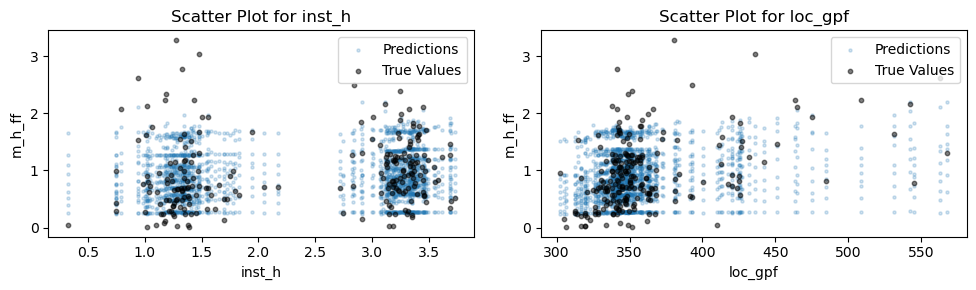

In [43]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_gt_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

#### Histogram-based gradient trees quantile regression

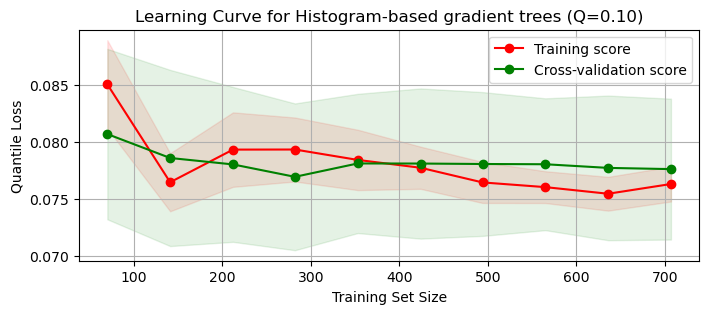

Cross-validated quantile loss: 0.0776 ± 0.0062
Quantile Loss on Train Set: 0.0763
Quantile Loss on Test Set: 0.0765




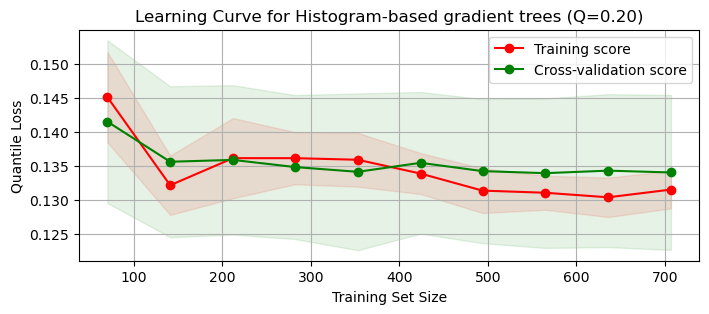

Cross-validated quantile loss: 0.1340 ± 0.0114
Quantile Loss on Train Set: 0.1318
Quantile Loss on Test Set: 0.1303




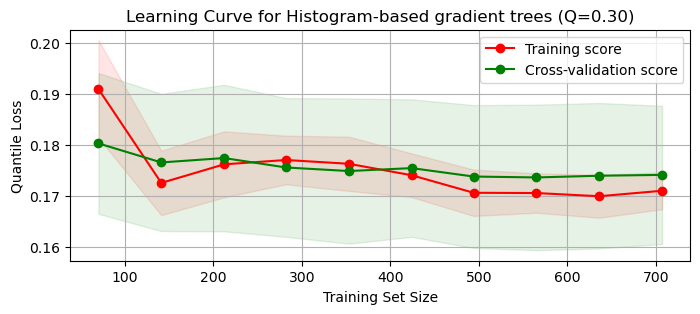

Cross-validated quantile loss: 0.1742 ± 0.0136
Quantile Loss on Train Set: 0.1712
Quantile Loss on Test Set: 0.1722




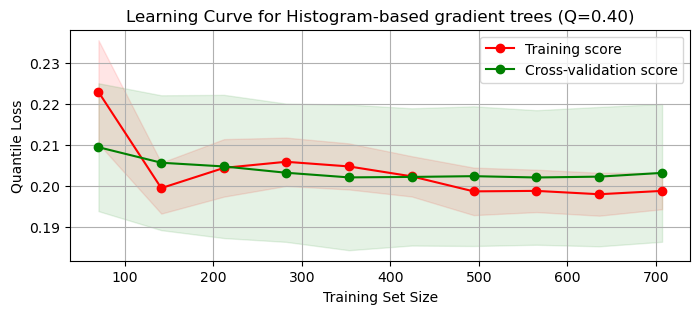

Cross-validated quantile loss: 0.2029 ± 0.0172
Quantile Loss on Train Set: 0.1990
Quantile Loss on Test Set: 0.1999




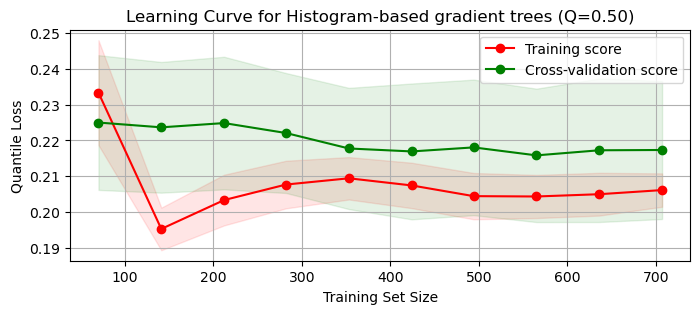

Cross-validated quantile loss: 0.2173 ± 0.0194
Quantile Loss on Train Set: 0.2069
Quantile Loss on Test Set: 0.2140




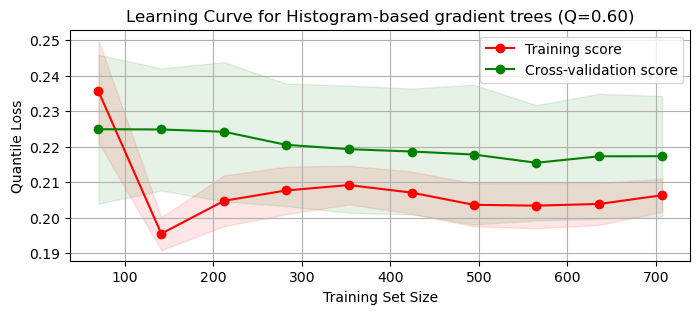

Cross-validated quantile loss: 0.2173 ± 0.0170
Quantile Loss on Train Set: 0.2067
Quantile Loss on Test Set: 0.2187




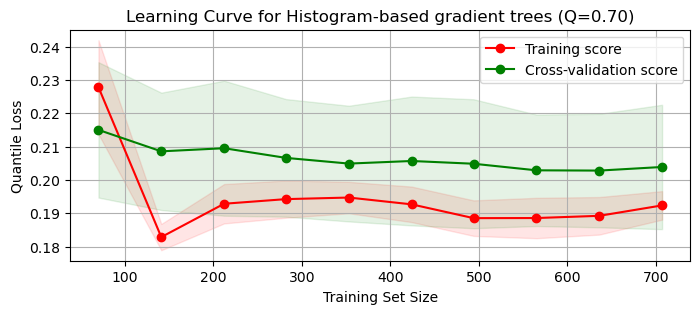

Cross-validated quantile loss: 0.2040 ± 0.0185
Quantile Loss on Train Set: 0.1930
Quantile Loss on Test Set: 0.2027




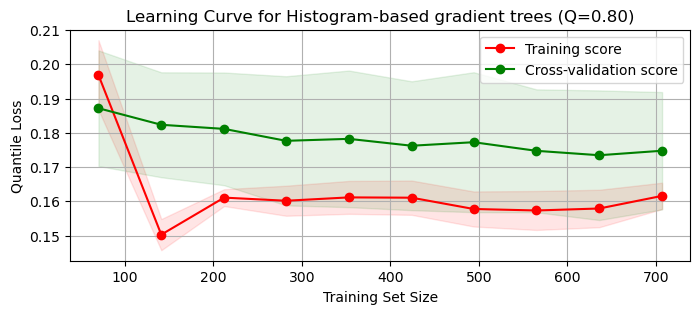

Cross-validated quantile loss: 0.1749 ± 0.0170
Quantile Loss on Train Set: 0.1629
Quantile Loss on Test Set: 0.1794




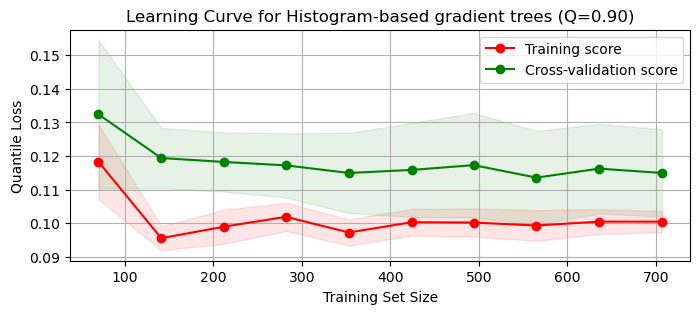

Cross-validated quantile loss: 0.1151 ± 0.0130
Quantile Loss on Train Set: 0.1009
Quantile Loss on Test Set: 0.1220




In [44]:
start_t = time.time()
models_hbgt_m_h_ff, predictions_hbgt_m_h_ff = store_ml_model_data('Histogram-based gradient trees', 
                                                                  X_train_scaled_m_h_ff, 
                                                                  y_train_m_h_ff, 
                                                                  X_test_scaled_m_h_ff, 
                                                                  y_test_m_h_ff, 
                                                                  k_folds, 
                                                                  quantiles)
finish_t = time.time()

In [45]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 420.82s


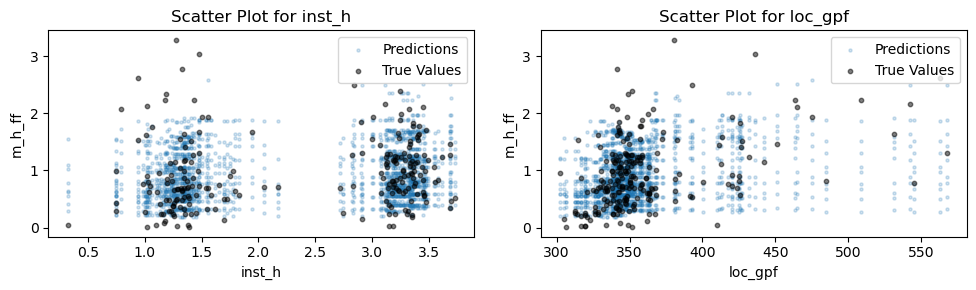

In [46]:
plot_predict_scatter(X_test_m_h_ff, y_test_m_h_ff, predictions_hbgt_m_h_ff, quantiles, predictors_m_h_ff, targets[0])

### Vertical movement prediction

#### Feature selection

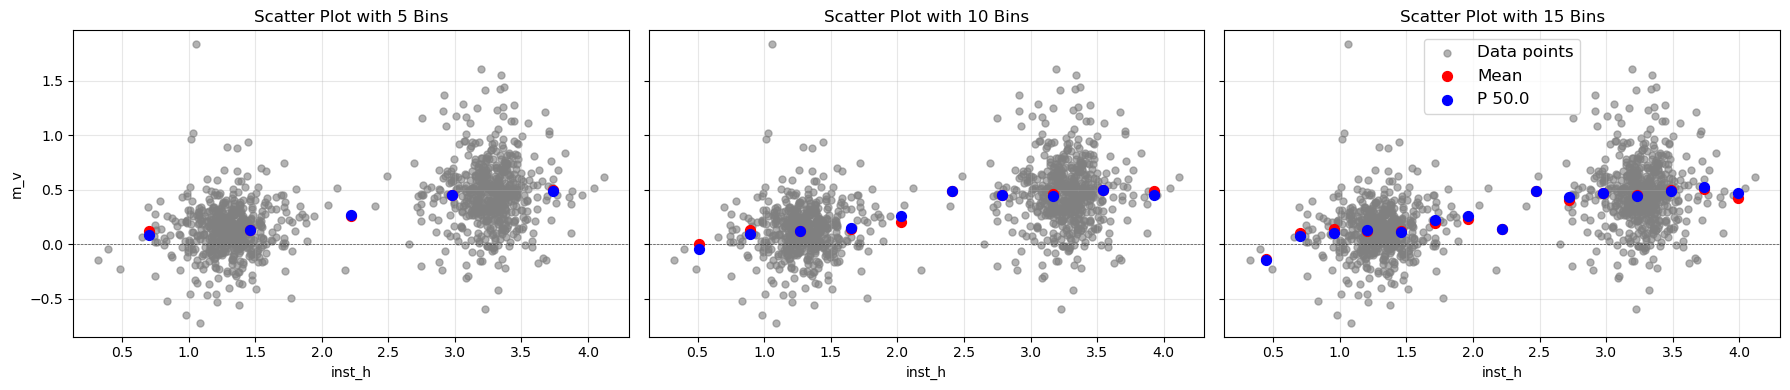

In [47]:
plot_binned_scatterplots(df, 'inst_h', 'm_v', bin_list=[5, 10, 15], tau=0.5)

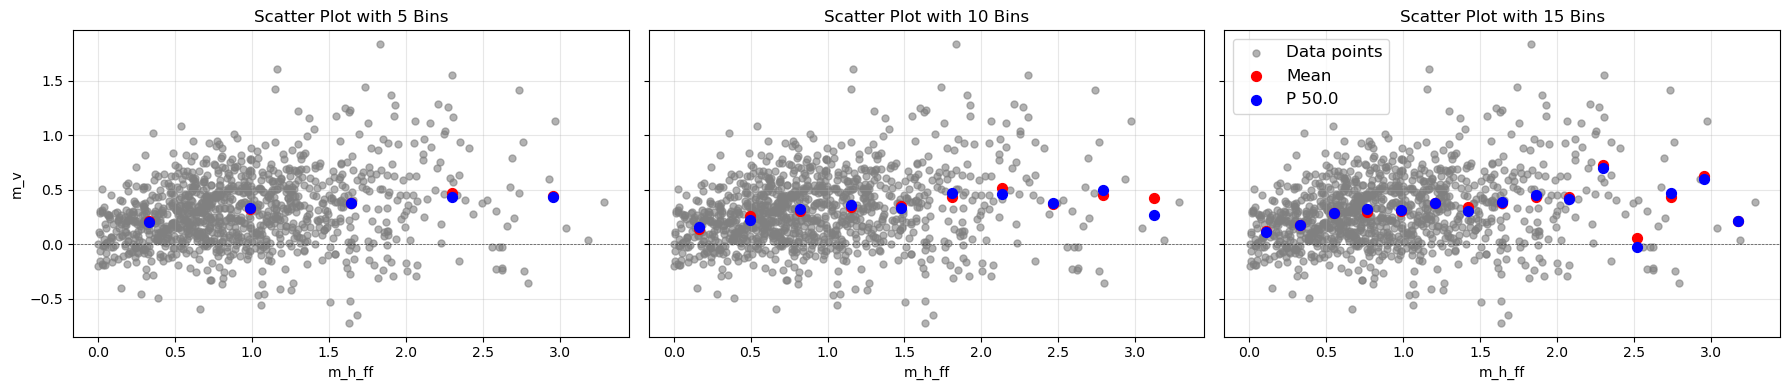

In [48]:
plot_binned_scatterplots(df, 'm_h_ff', 'm_v', bin_list=[5, 10, 15], tau=0.5)

#### Training preparation

In [49]:
k_folds = 5
partition = 0.2

In [50]:
predictors_m_v = [
    'inst_h',
    'm_h_ff'
]

In [51]:
train_m_v, test_m_v = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_v, y_train_m_v = train_m_v[predictors_m_v], train_m_v[targets[1]]
X_test_m_v, y_test_m_v = test_m_v[predictors_m_v], test_m_v[targets[1]]

# Initialize QuantileTransformer for the target column
x_scaler_m_v = StandardScaler()

# Scale X (features)
X_train_scaled_m_v = x_scaler_m_v.fit_transform(X_train_m_v)
X_test_scaled_m_v = x_scaler_m_v.transform(X_test_m_v)

#### Linear quantile regression

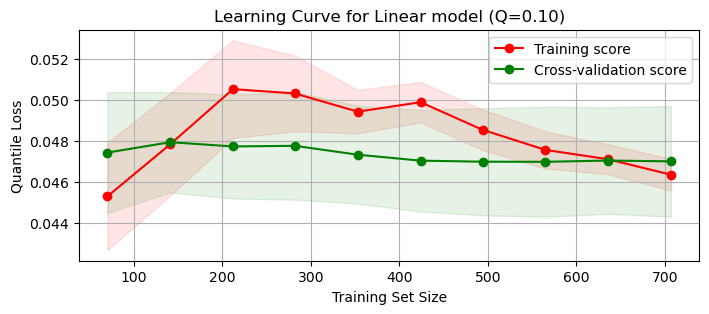

Cross-validated quantile loss: 0.0470 ± 0.0027
Quantile Loss on Train Set: 0.0464
Quantile Loss on Test Set: 0.0471




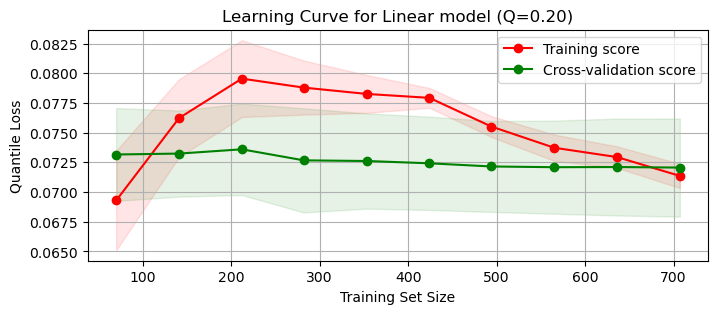

Cross-validated quantile loss: 0.0721 ± 0.0041
Quantile Loss on Train Set: 0.0715
Quantile Loss on Test Set: 0.0719




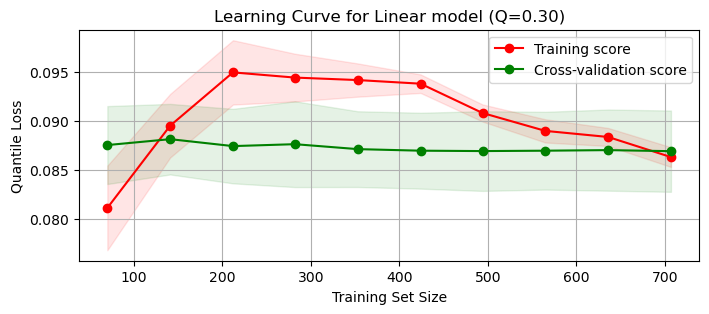

Cross-validated quantile loss: 0.0870 ± 0.0041
Quantile Loss on Train Set: 0.0864
Quantile Loss on Test Set: 0.0855




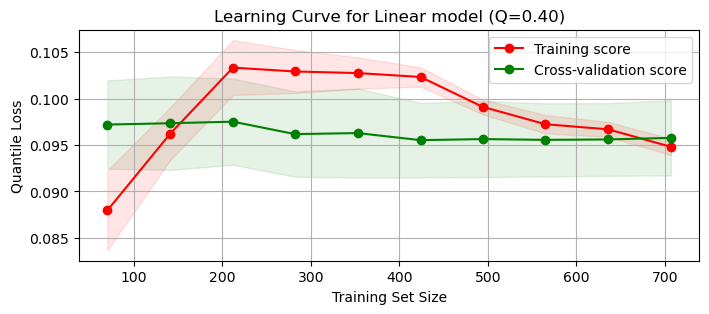

Cross-validated quantile loss: 0.0958 ± 0.0041
Quantile Loss on Train Set: 0.0949
Quantile Loss on Test Set: 0.0941




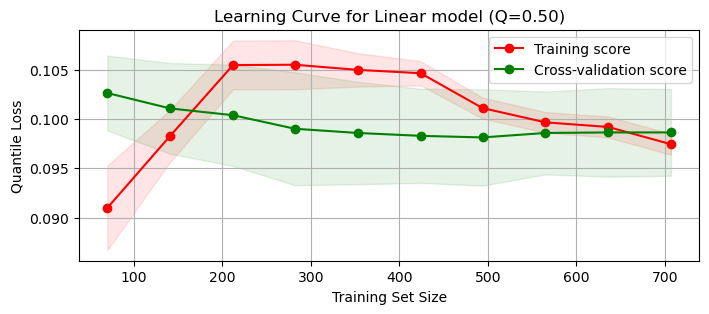

Cross-validated quantile loss: 0.0986 ± 0.0045
Quantile Loss on Train Set: 0.0976
Quantile Loss on Test Set: 0.0974




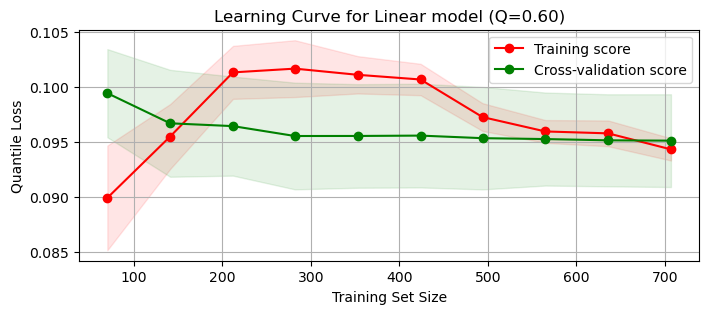

Cross-validated quantile loss: 0.0951 ± 0.0043
Quantile Loss on Train Set: 0.0944
Quantile Loss on Test Set: 0.0924




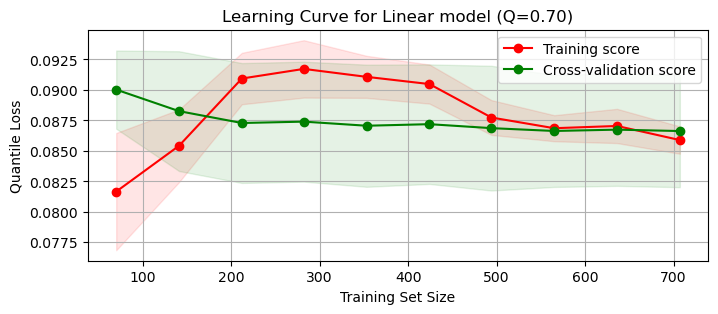

Cross-validated quantile loss: 0.0866 ± 0.0046
Quantile Loss on Train Set: 0.0860
Quantile Loss on Test Set: 0.0832




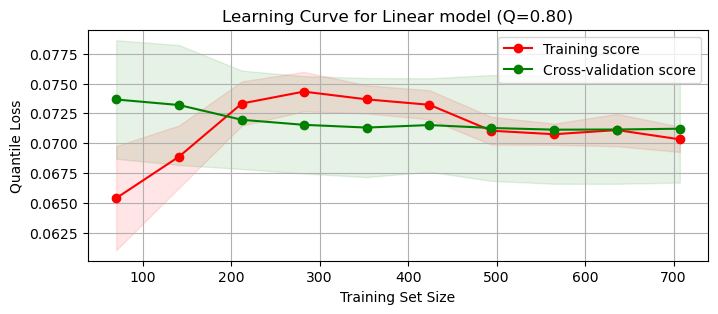

Cross-validated quantile loss: 0.0712 ± 0.0045
Quantile Loss on Train Set: 0.0705
Quantile Loss on Test Set: 0.0702




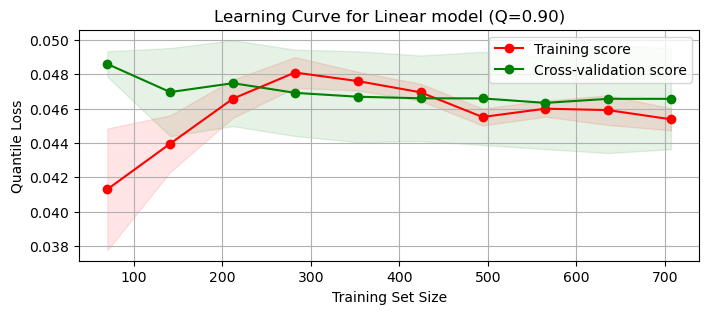

Cross-validated quantile loss: 0.0466 ± 0.0029
Quantile Loss on Train Set: 0.0455
Quantile Loss on Test Set: 0.0471




In [52]:
start_t = time.time()
models_lqr_m_v, predictions_lqr_m_v = store_ml_model_data('Linear model', 
                                                          X_train_scaled_m_v, 
                                                          y_train_m_v, 
                                                          X_test_scaled_m_v, 
                                                          y_test_m_v, 
                                                          k_folds, 
                                                          quantiles)
finish_t = time.time()

In [53]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 32.40s


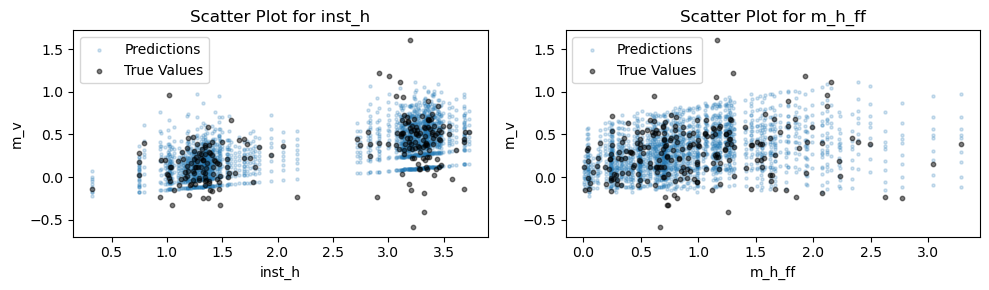

In [54]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_lqr_m_v, quantiles, predictors_m_v, targets[1])

#### Gradient boosted trees quantile regression

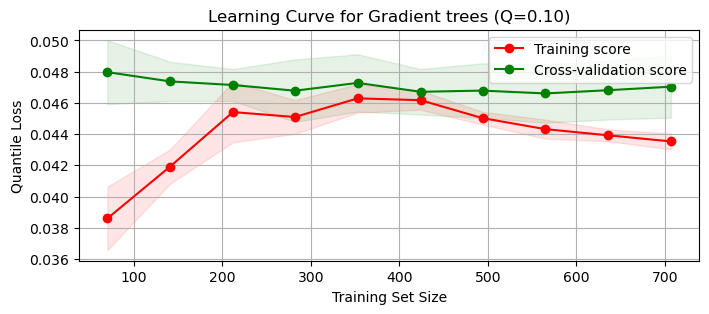

Cross-validated quantile loss: 0.0471 ± 0.0020
Quantile Loss on Train Set: 0.0438
Quantile Loss on Test Set: 0.0467




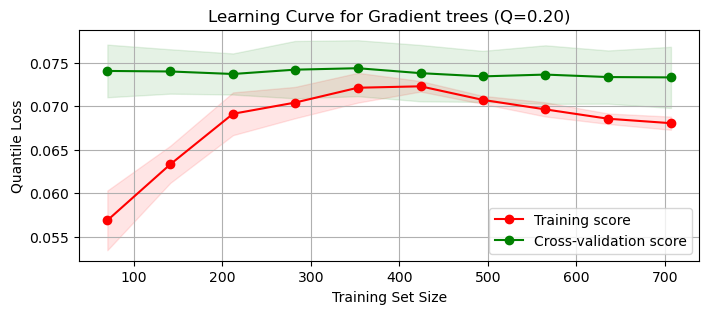

Cross-validated quantile loss: 0.0733 ± 0.0033
Quantile Loss on Train Set: 0.0690
Quantile Loss on Test Set: 0.0726




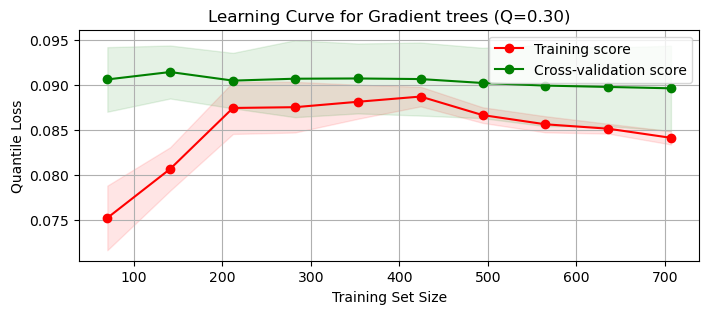

Cross-validated quantile loss: 0.0899 ± 0.0047
Quantile Loss on Train Set: 0.0851
Quantile Loss on Test Set: 0.0894




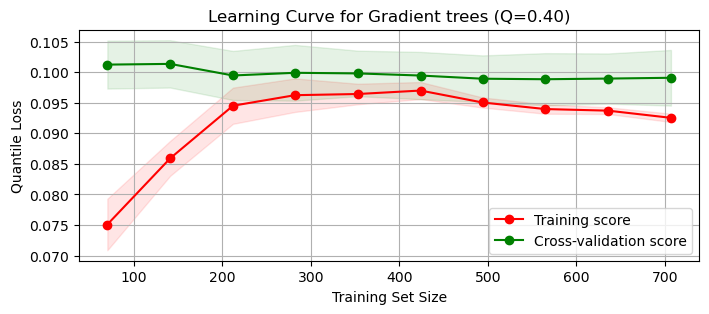

Cross-validated quantile loss: 0.0990 ± 0.0045
Quantile Loss on Train Set: 0.0936
Quantile Loss on Test Set: 0.0967




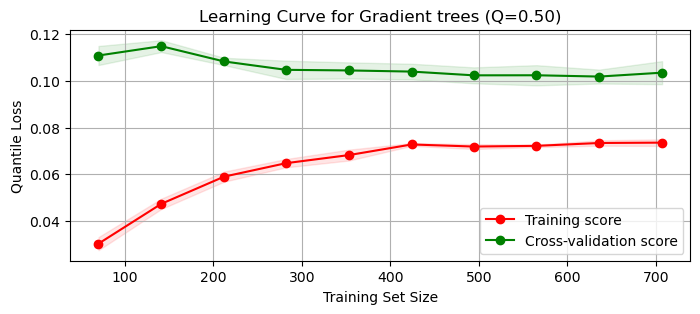

Cross-validated quantile loss: 0.1024 ± 0.0030
Quantile Loss on Train Set: 0.0771
Quantile Loss on Test Set: 0.1025




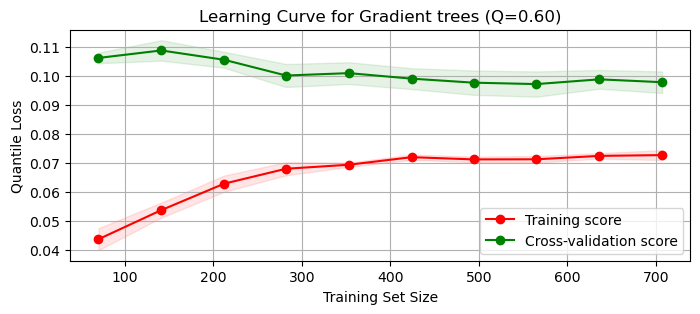

Cross-validated quantile loss: 0.0969 ± 0.0035
Quantile Loss on Train Set: 0.0759
Quantile Loss on Test Set: 0.0977




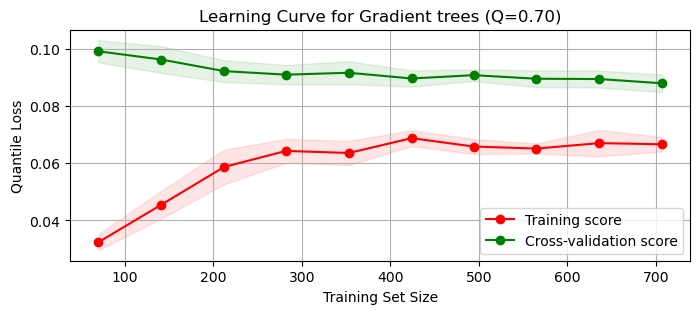

Cross-validated quantile loss: 0.0866 ± 0.0025
Quantile Loss on Train Set: 0.0678
Quantile Loss on Test Set: 0.0853




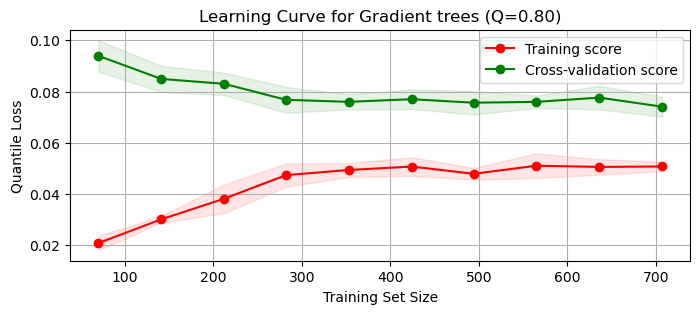

Cross-validated quantile loss: 0.0748 ± 0.0039
Quantile Loss on Train Set: 0.0543
Quantile Loss on Test Set: 0.0709




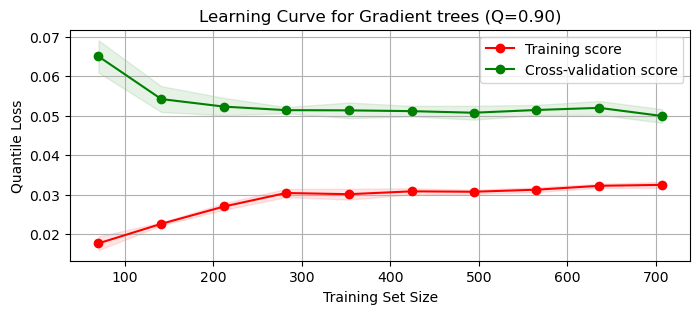

Cross-validated quantile loss: 0.0501 ± 0.0015
Quantile Loss on Train Set: 0.0337
Quantile Loss on Test Set: 0.0467




In [55]:
start_t = time.time()
models_gt_m_v, predictions_gt_m_v = store_ml_model_data('Gradient trees', 
                                                        X_train_scaled_m_v, 
                                                        y_train_m_v, 
                                                        X_test_scaled_m_v, 
                                                        y_test_m_v, 
                                                        k_folds, 
                                                        quantiles)
finish_t = time.time()

In [56]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 438.94s


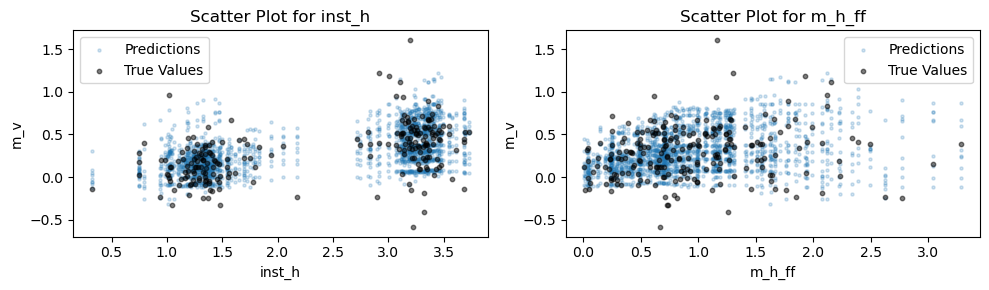

In [57]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_gt_m_v, quantiles, predictors_m_v, targets[1])

#### Histogram-based gradient trees quantile regression

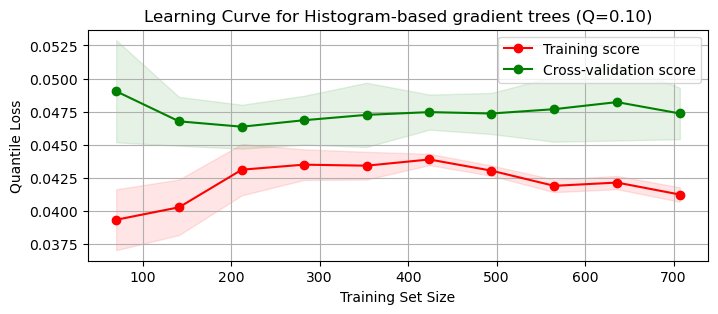

Cross-validated quantile loss: 0.0474 ± 0.0018
Quantile Loss on Train Set: 0.0415
Quantile Loss on Test Set: 0.0492




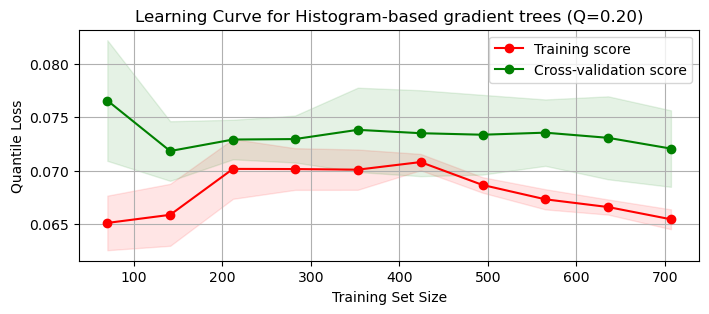

Cross-validated quantile loss: 0.0721 ± 0.0036
Quantile Loss on Train Set: 0.0657
Quantile Loss on Test Set: 0.0740




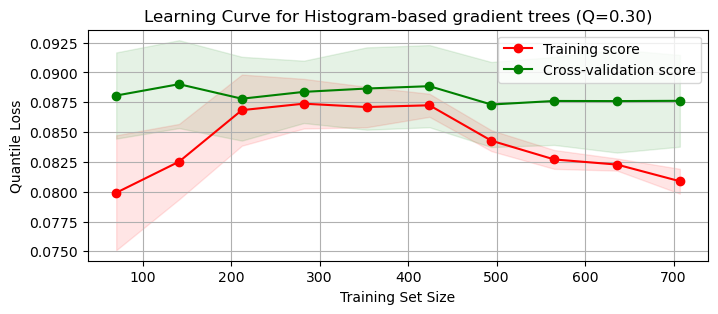

Cross-validated quantile loss: 0.0876 ± 0.0038
Quantile Loss on Train Set: 0.0809
Quantile Loss on Test Set: 0.0870




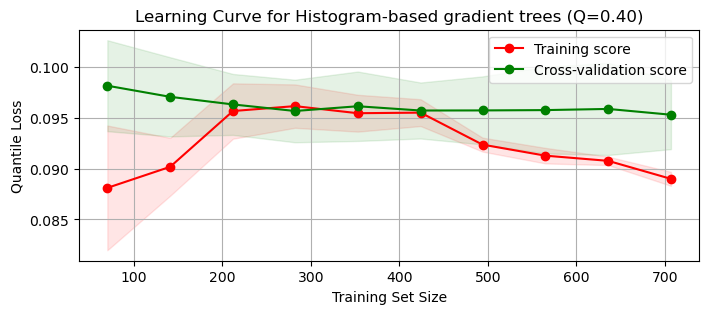

Cross-validated quantile loss: 0.0955 ± 0.0032
Quantile Loss on Train Set: 0.0900
Quantile Loss on Test Set: 0.0952




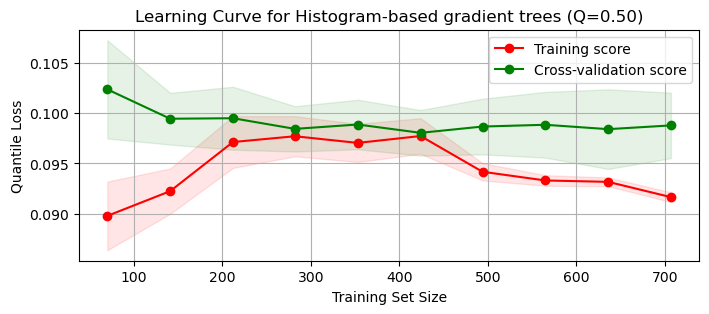

Cross-validated quantile loss: 0.0987 ± 0.0033
Quantile Loss on Train Set: 0.0925
Quantile Loss on Test Set: 0.0985




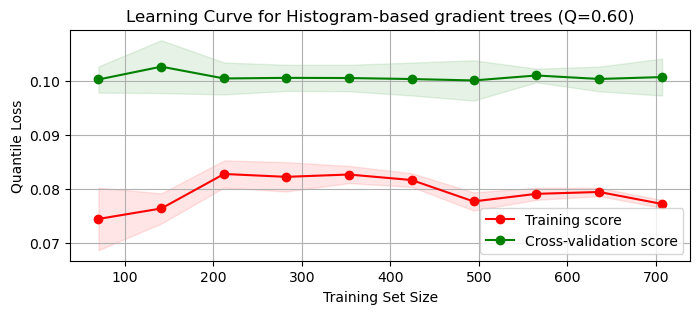

Cross-validated quantile loss: 0.1005 ± 0.0038
Quantile Loss on Train Set: 0.0781
Quantile Loss on Test Set: 0.1043




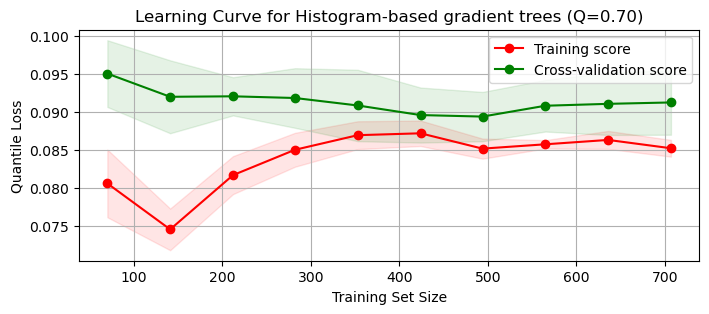

Cross-validated quantile loss: 0.0913 ± 0.0043
Quantile Loss on Train Set: 0.0861
Quantile Loss on Test Set: 0.0905




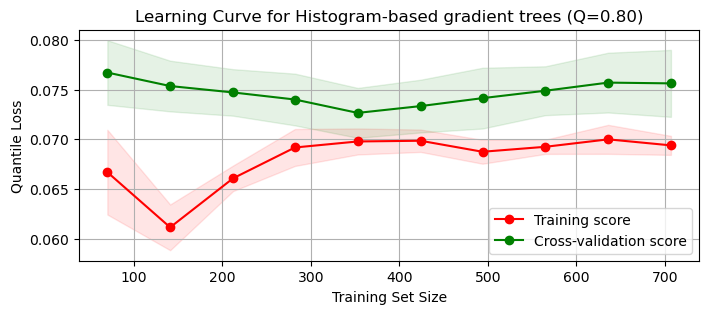

Cross-validated quantile loss: 0.0755 ± 0.0033
Quantile Loss on Train Set: 0.0702
Quantile Loss on Test Set: 0.0740




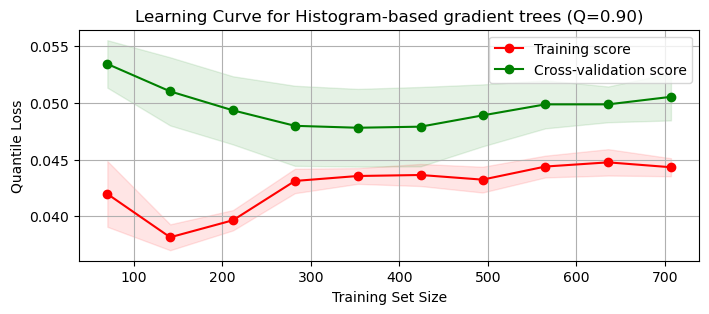

Cross-validated quantile loss: 0.0505 ± 0.0022
Quantile Loss on Train Set: 0.0453
Quantile Loss on Test Set: 0.0512




In [58]:
start_t = time.time()
models_hbgt_m_v, predictions_hbgt_m_v = store_ml_model_data('Histogram-based gradient trees', 
                                                            X_train_scaled_m_v, 
                                                            y_train_m_v, 
                                                            X_test_scaled_m_v, 
                                                            y_test_m_v, 
                                                            k_folds, 
                                                            quantiles)
finish_t = time.time()

In [59]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 435.46s


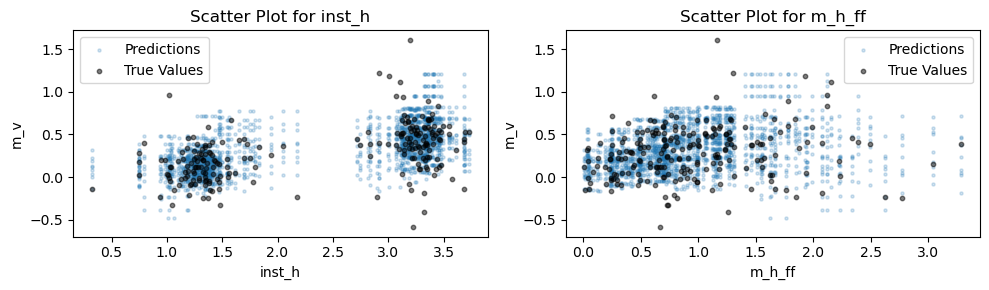

In [60]:
plot_predict_scatter(X_test_m_v, y_test_m_v, predictions_hbgt_m_v, quantiles, predictors_m_v, targets[1])

### Horizontal movement devation prediction

#### Feature selection

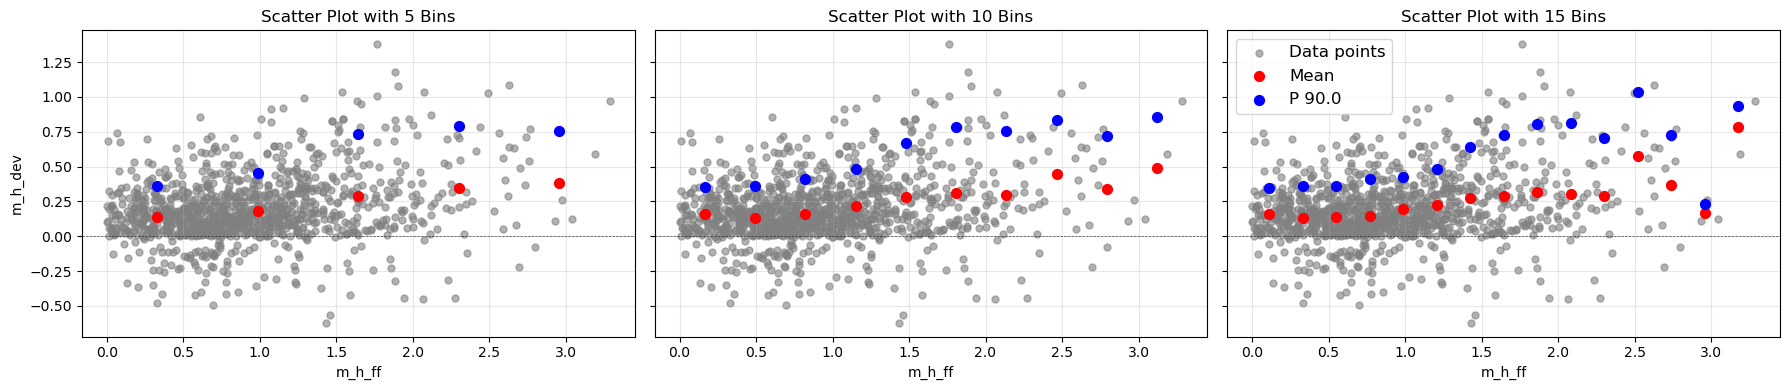

In [61]:
plot_binned_scatterplots(df, 'm_h_ff', 'm_h_dev', bin_list=[5, 10, 15], tau=0.9)

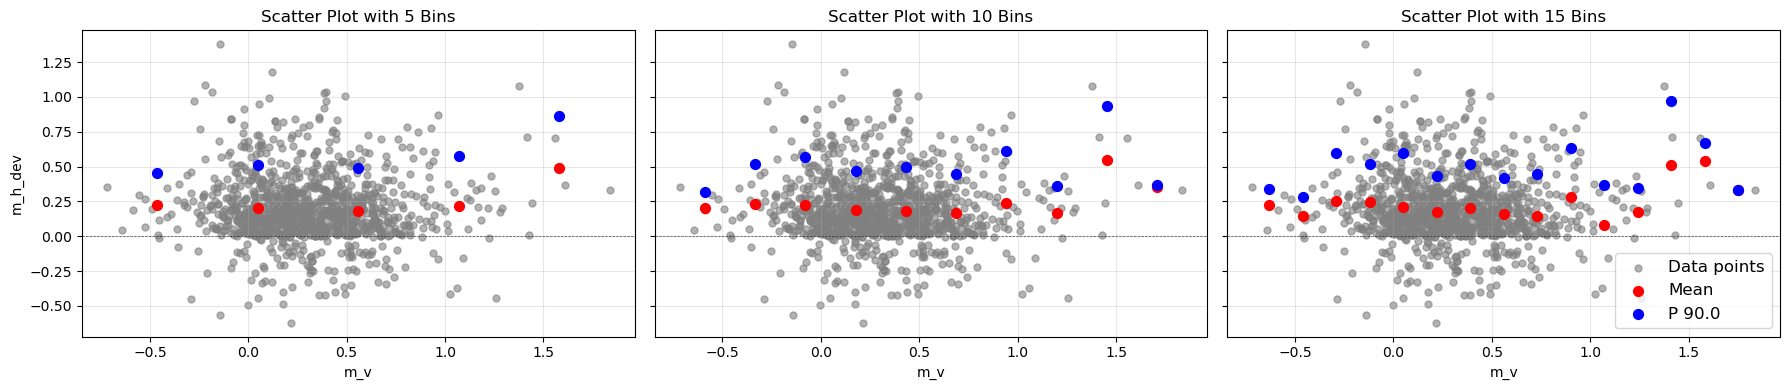

In [62]:
plot_binned_scatterplots(df, 'm_v', 'm_h_dev', bin_list=[5, 10, 15], tau=0.9)

#### Training preparation

In [63]:
k_folds = 5
partition = 0.2

In [64]:
predictors_m_h_dev = [
    'm_h_ff',
    'm_v'
]

In [65]:
train_m_h_dev, test_m_h_dev = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_m_h_dev, y_train_m_h_dev = train_m_h_dev[predictors_m_h_dev], train_m_h_dev[targets[2]]
X_test_m_h_dev, y_test_m_h_dev = test_m_h_dev[predictors_m_h_dev], test_m_h_dev[targets[2]]

# Initialize QuantileTransformer for the target column
x_scaler_m_h_dev = StandardScaler()

# Scale X (features)
X_train_scaled_m_h_dev = x_scaler_m_h_dev.fit_transform(X_train_m_h_dev)
X_test_scaled_m_h_dev = x_scaler_m_h_dev.transform(X_test_m_h_dev)

#### Linear quantile regression

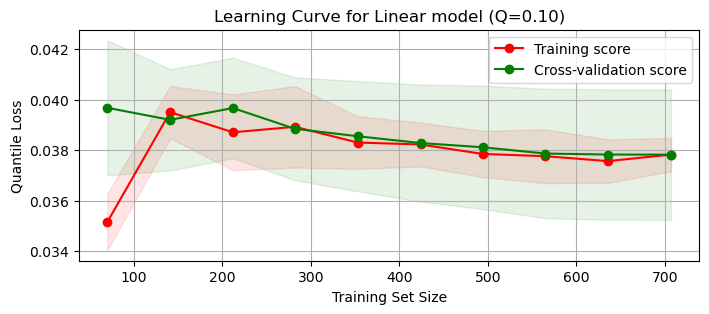

Cross-validated quantile loss: 0.0378 ± 0.0026
Quantile Loss on Train Set: 0.0378
Quantile Loss on Test Set: 0.0446




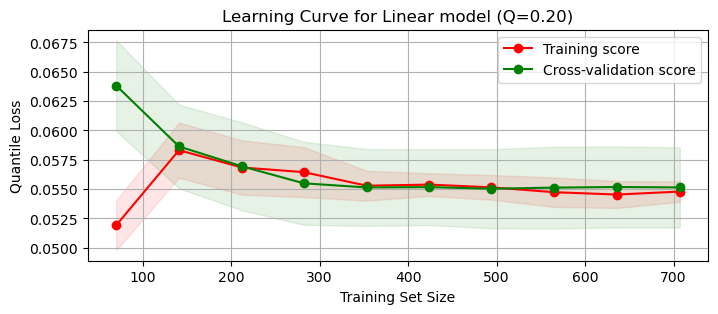

Cross-validated quantile loss: 0.0551 ± 0.0034
Quantile Loss on Train Set: 0.0548
Quantile Loss on Test Set: 0.0634




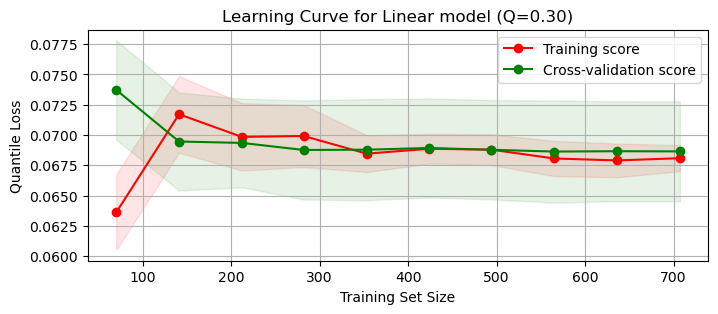

Cross-validated quantile loss: 0.0686 ± 0.0041
Quantile Loss on Train Set: 0.0681
Quantile Loss on Test Set: 0.0778




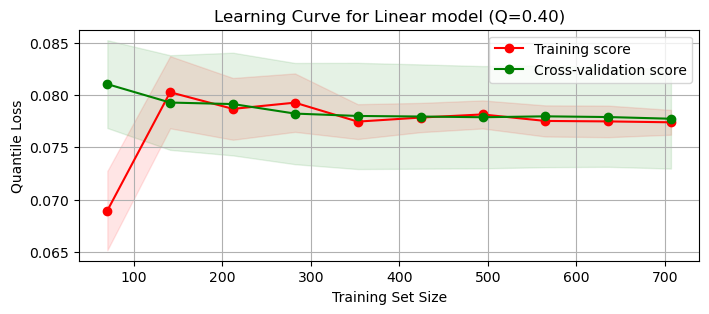

Cross-validated quantile loss: 0.0777 ± 0.0048
Quantile Loss on Train Set: 0.0774
Quantile Loss on Test Set: 0.0876




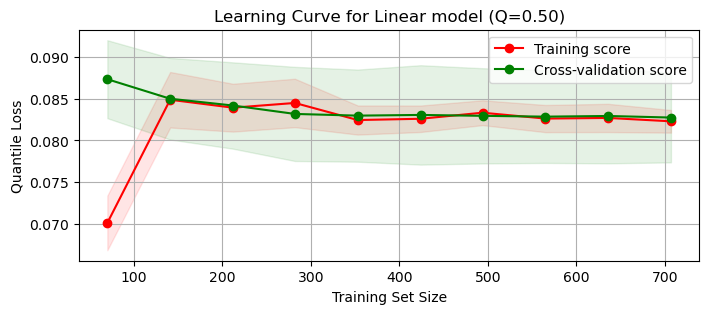

Cross-validated quantile loss: 0.0827 ± 0.0054
Quantile Loss on Train Set: 0.0823
Quantile Loss on Test Set: 0.0927




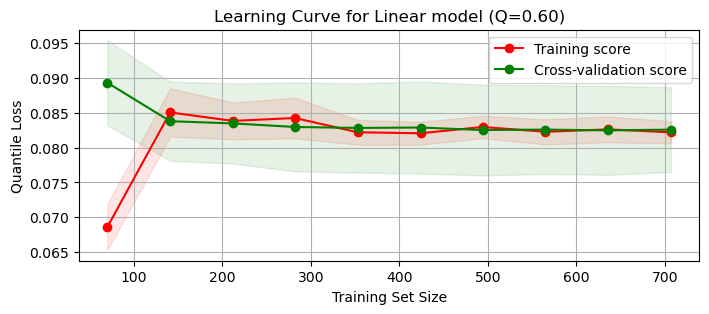

Cross-validated quantile loss: 0.0825 ± 0.0061
Quantile Loss on Train Set: 0.0822
Quantile Loss on Test Set: 0.0936




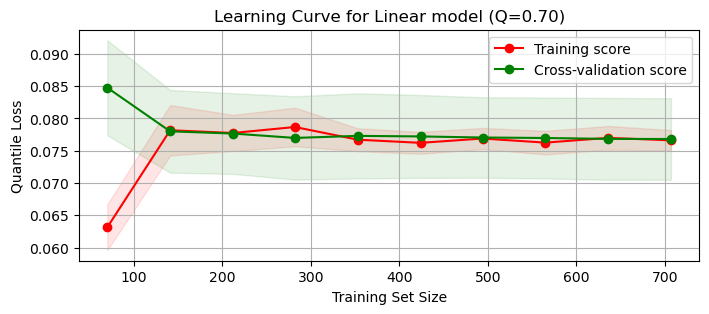

Cross-validated quantile loss: 0.0768 ± 0.0063
Quantile Loss on Train Set: 0.0766
Quantile Loss on Test Set: 0.0888




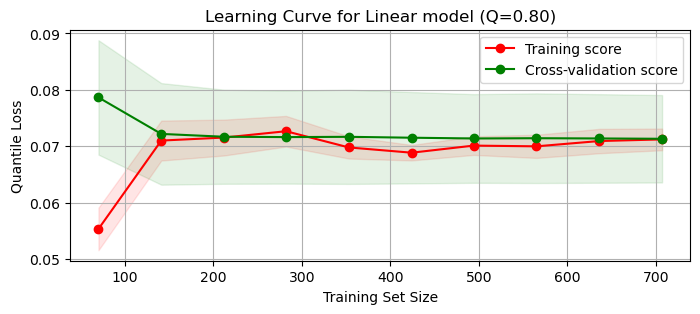

Cross-validated quantile loss: 0.0713 ± 0.0078
Quantile Loss on Train Set: 0.0712
Quantile Loss on Test Set: 0.0808




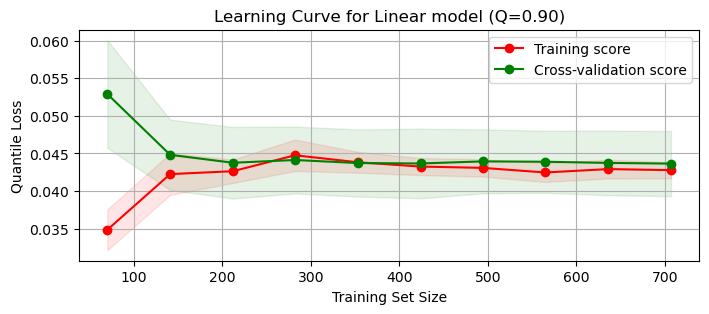

Cross-validated quantile loss: 0.0437 ± 0.0043
Quantile Loss on Train Set: 0.0429
Quantile Loss on Test Set: 0.0498




In [66]:
start_t = time.time()
models_lqr_m_h_dev, predictions_lqr_m_h_dev = store_ml_model_data('Linear model', 
                                                                  X_train_scaled_m_h_dev, 
                                                                  y_train_m_h_dev, 
                                                                  X_test_scaled_m_h_dev, 
                                                                  y_test_m_h_dev, 
                                                                  k_folds, 
                                                                  quantiles)
finish_t = time.time()

In [67]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 31.63s


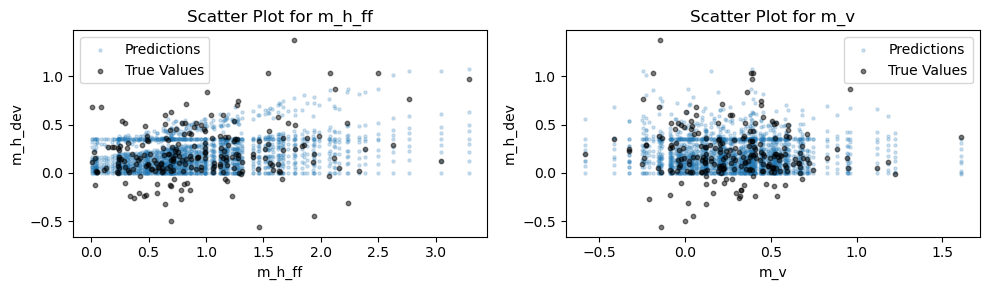

In [68]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_lqr_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

#### Gradient boosted trees quantile regression

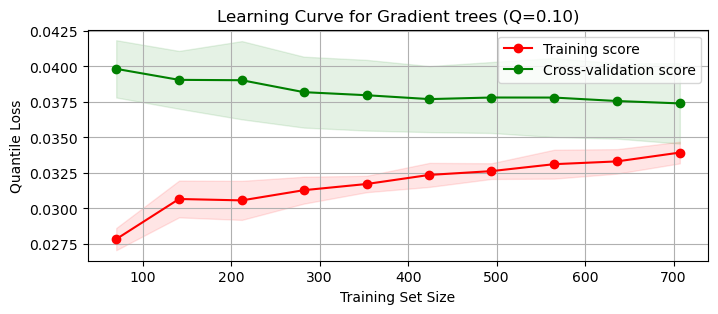

Cross-validated quantile loss: 0.0374 ± 0.0028
Quantile Loss on Train Set: 0.0342
Quantile Loss on Test Set: 0.0451




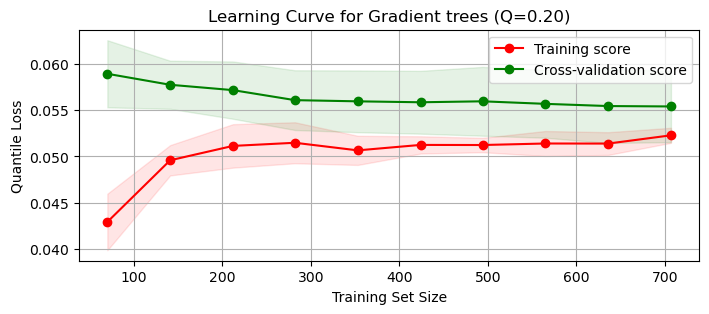

Cross-validated quantile loss: 0.0554 ± 0.0038
Quantile Loss on Train Set: 0.0522
Quantile Loss on Test Set: 0.0642




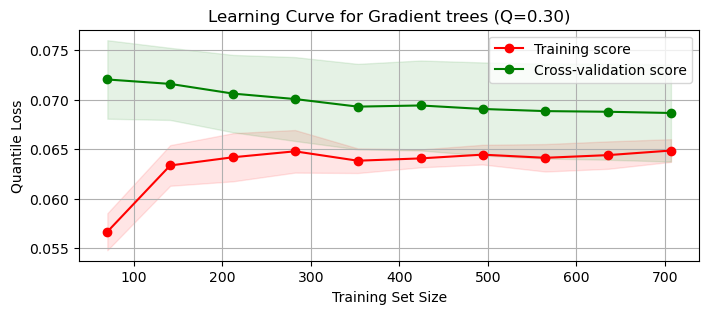

Cross-validated quantile loss: 0.0687 ± 0.0049
Quantile Loss on Train Set: 0.0653
Quantile Loss on Test Set: 0.0789




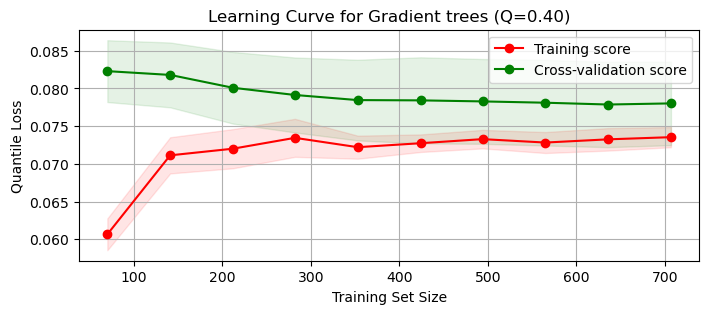

Cross-validated quantile loss: 0.0781 ± 0.0058
Quantile Loss on Train Set: 0.0739
Quantile Loss on Test Set: 0.0897




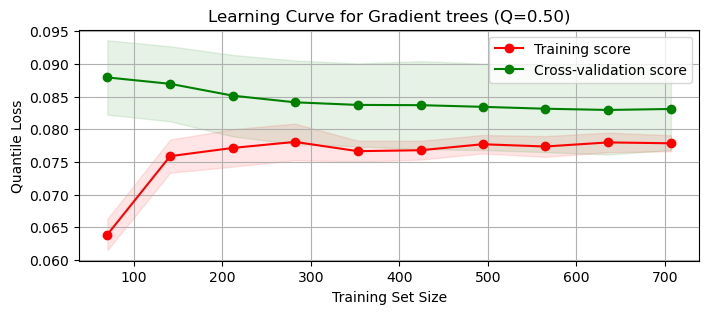

Cross-validated quantile loss: 0.0831 ± 0.0065
Quantile Loss on Train Set: 0.0785
Quantile Loss on Test Set: 0.0952




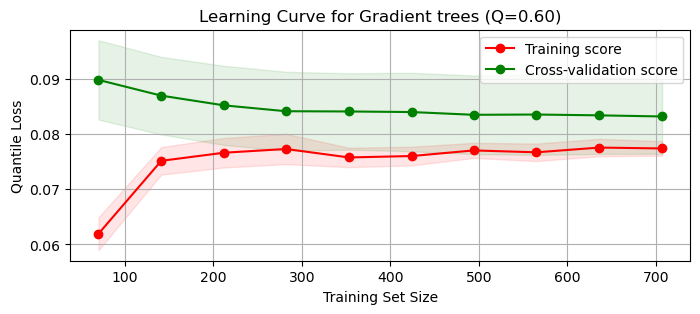

Cross-validated quantile loss: 0.0831 ± 0.0068
Quantile Loss on Train Set: 0.0780
Quantile Loss on Test Set: 0.0968




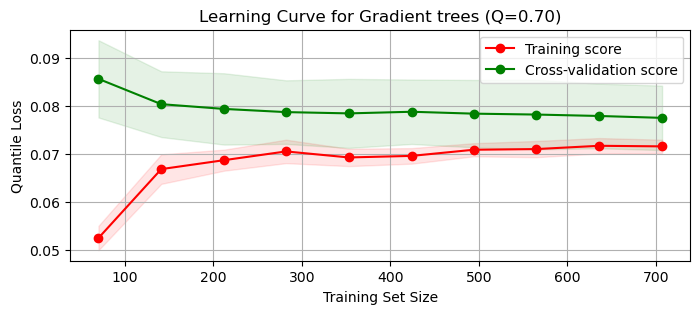

Cross-validated quantile loss: 0.0776 ± 0.0067
Quantile Loss on Train Set: 0.0725
Quantile Loss on Test Set: 0.0906




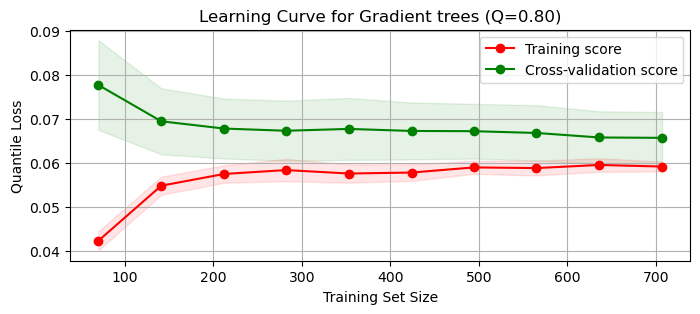

Cross-validated quantile loss: 0.0656 ± 0.0058
Quantile Loss on Train Set: 0.0595
Quantile Loss on Test Set: 0.0799




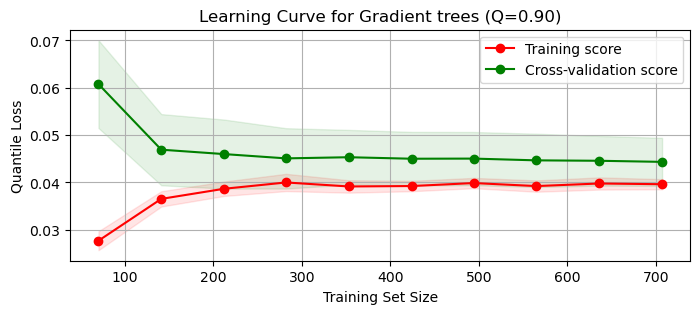

Cross-validated quantile loss: 0.0443 ± 0.0050
Quantile Loss on Train Set: 0.0399
Quantile Loss on Test Set: 0.0547




In [69]:
start_t = time.time()
models_gt_m_h_dev, predictions_gt_m_h_dev = store_ml_model_data('Gradient trees', 
                                                                X_train_scaled_m_h_dev, 
                                                                y_train_m_h_dev, 
                                                                X_test_scaled_m_h_dev, 
                                                                y_test_m_h_dev, 
                                                                k_folds, 
                                                                quantiles)
finish_t = time.time()

In [70]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 452.85s


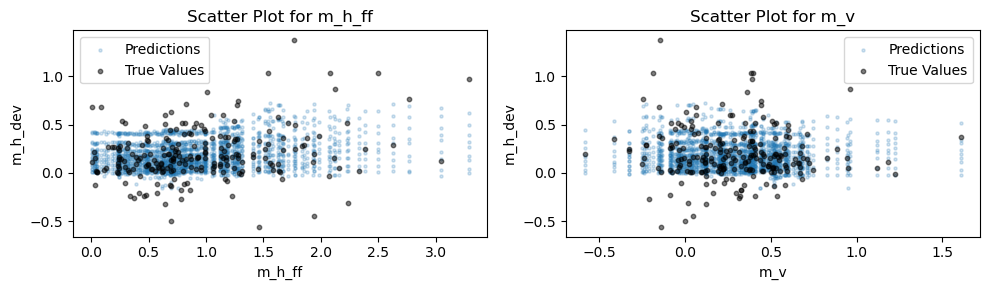

In [71]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_gt_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

#### Histogram-based gradient trees quantile regression

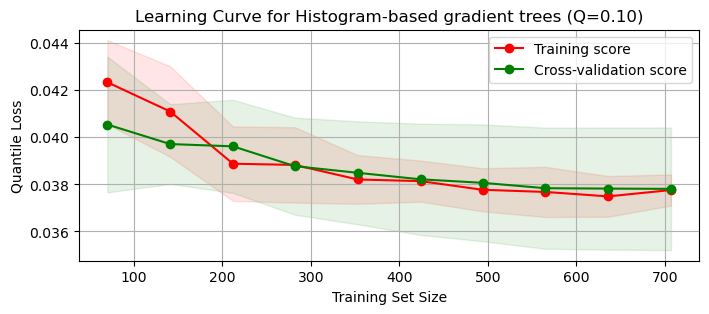

Cross-validated quantile loss: 0.0378 ± 0.0026
Quantile Loss on Train Set: 0.0378
Quantile Loss on Test Set: 0.0446




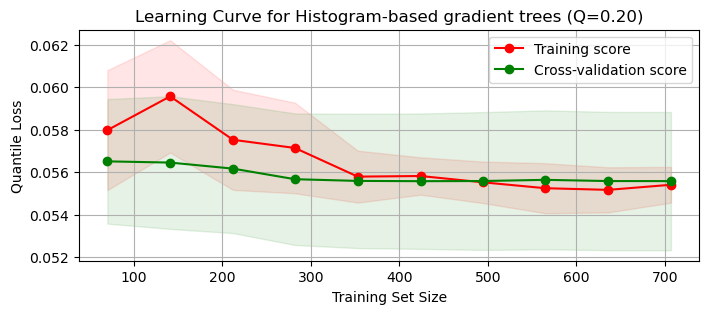

Cross-validated quantile loss: 0.0556 ± 0.0033
Quantile Loss on Train Set: 0.0554
Quantile Loss on Test Set: 0.0636




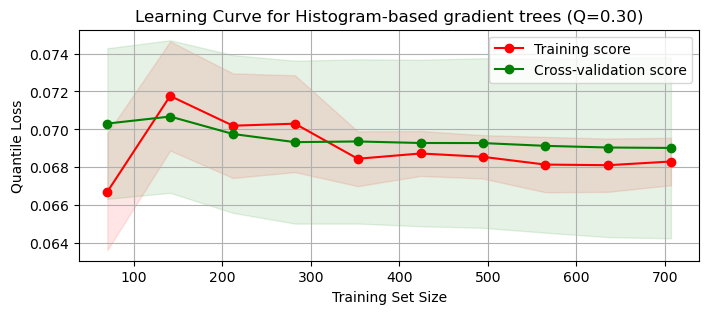

Cross-validated quantile loss: 0.0690 ± 0.0048
Quantile Loss on Train Set: 0.0682
Quantile Loss on Test Set: 0.0785




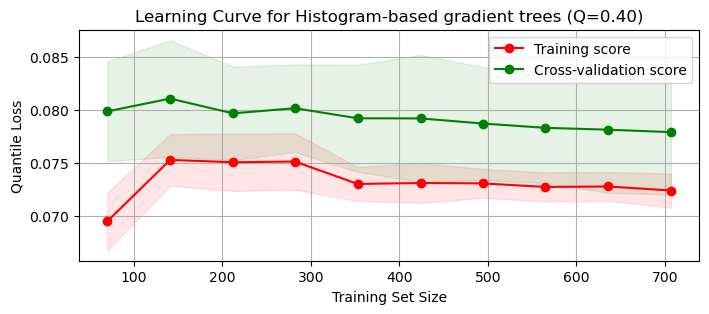

Cross-validated quantile loss: 0.0781 ± 0.0057
Quantile Loss on Train Set: 0.0727
Quantile Loss on Test Set: 0.0911




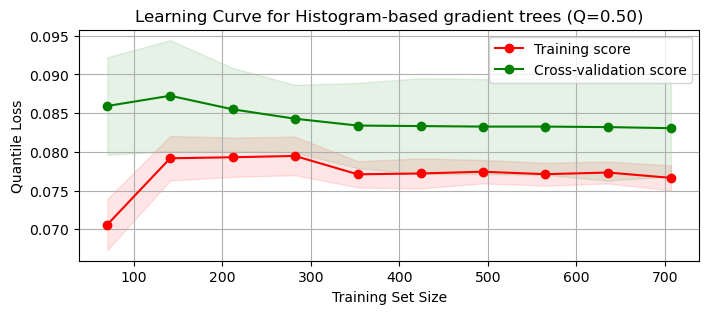

Cross-validated quantile loss: 0.0830 ± 0.0062
Quantile Loss on Train Set: 0.0769
Quantile Loss on Test Set: 0.0975




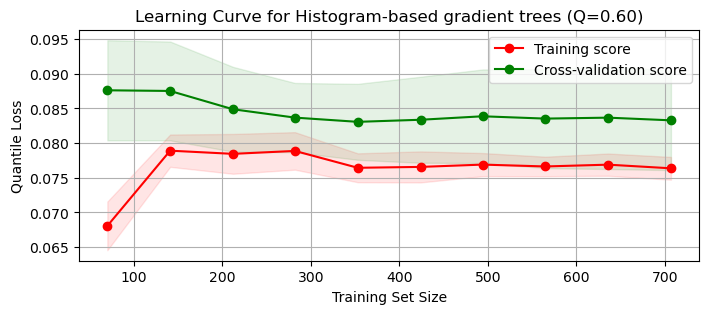

Cross-validated quantile loss: 0.0833 ± 0.0071
Quantile Loss on Train Set: 0.0764
Quantile Loss on Test Set: 0.0992




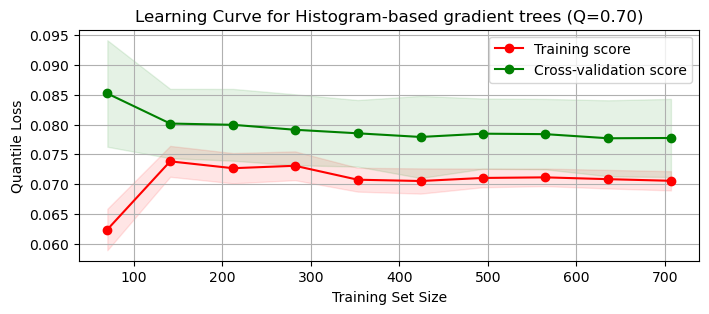

Cross-validated quantile loss: 0.0779 ± 0.0064
Quantile Loss on Train Set: 0.0710
Quantile Loss on Test Set: 0.0924




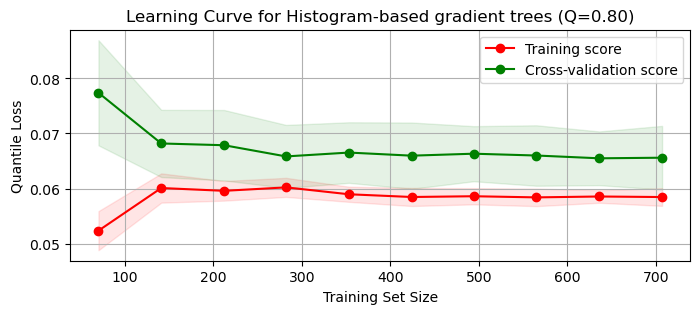

Cross-validated quantile loss: 0.0656 ± 0.0058
Quantile Loss on Train Set: 0.0591
Quantile Loss on Test Set: 0.0810




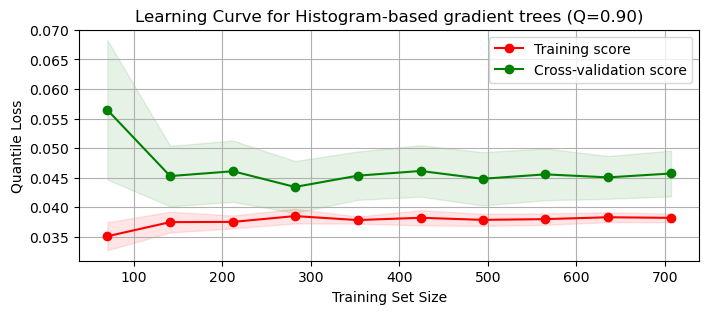

Cross-validated quantile loss: 0.0456 ± 0.0039
Quantile Loss on Train Set: 0.0388
Quantile Loss on Test Set: 0.0521




In [72]:
start_t = time.time()
models_hbgt_m_h_dev, predictions_hbgt_m_h_dev = store_ml_model_data('Histogram-based gradient trees', 
                                                                    X_train_scaled_m_h_dev, 
                                                                    y_train_m_h_dev, 
                                                                    X_test_scaled_m_h_dev, 
                                                                    y_test_m_h_dev, 
                                                                    k_folds, 
                                                                    quantiles)
finish_t = time.time()

In [73]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 457.65s


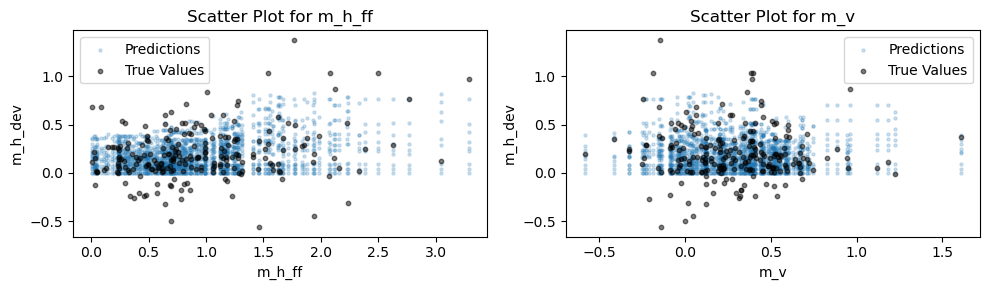

In [74]:
plot_predict_scatter(X_test_m_h_dev, y_test_m_h_dev, predictions_hbgt_m_h_dev, quantiles, predictors_m_h_dev, targets[2])

### Post-blast detection depth prediction

#### Feature selection

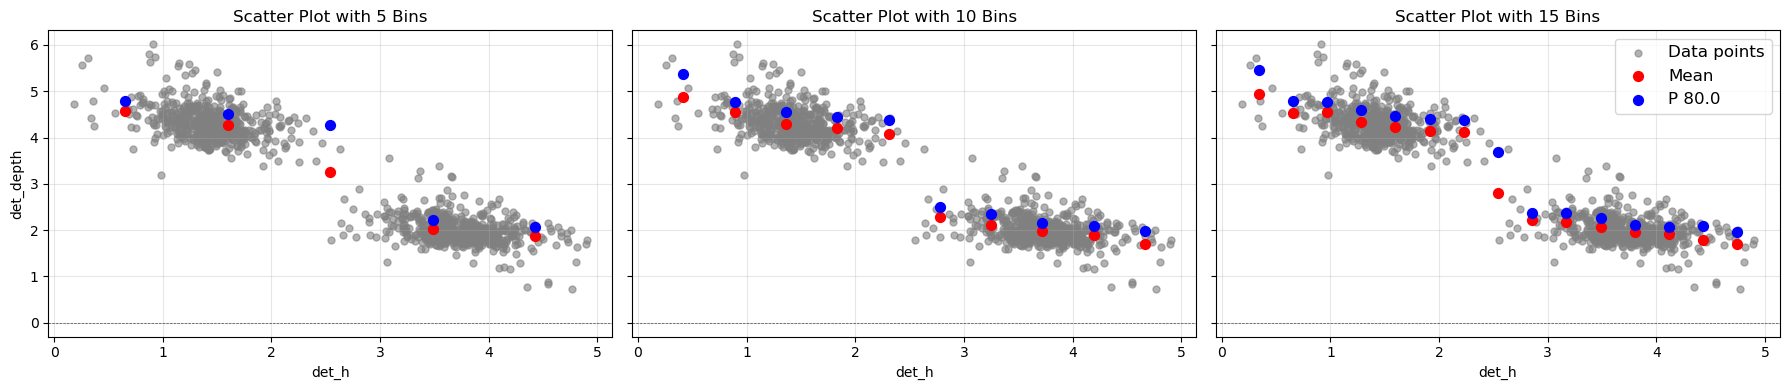

In [75]:
plot_binned_scatterplots(df, 'det_h', 'det_depth', bin_list=[5, 10, 15], tau=0.8)

#### Training preparation

In [76]:
k_folds = 5
partition = 0.2

In [77]:
predictors_det_depth = [
    'det_h'
]

In [78]:
train_det_depth, test_det_depth = train_test_split(df, test_size=partition, random_state=42)

# Separate features and target
X_train_det_depth, y_train_det_depth = train_det_depth[predictors_det_depth], train_det_depth[targets[3]]
X_test_det_depth, y_test_det_depth = test_det_depth[predictors_det_depth], test_det_depth[targets[3]]

# Initialize QuantileTransformer for the target column
x_scaler_det_depth = StandardScaler()

# Scale X (features)
X_train_scaled_det_depth = x_scaler_det_depth.fit_transform(X_train_det_depth)
X_test_scaled_det_depth = x_scaler_det_depth.transform(X_test_det_depth)

#### Linear qunatile regression

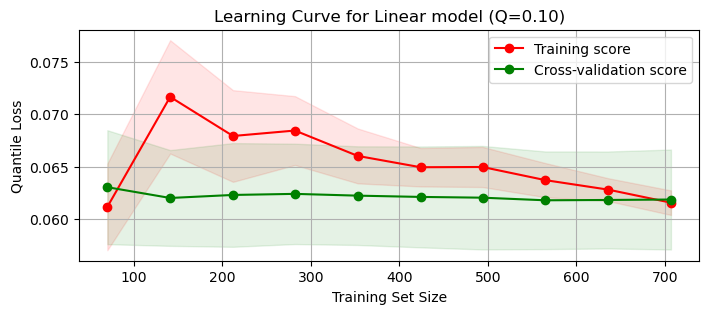

Cross-validated quantile loss: 0.0619 ± 0.0048
Quantile Loss on Train Set: 0.0616
Quantile Loss on Test Set: 0.0659




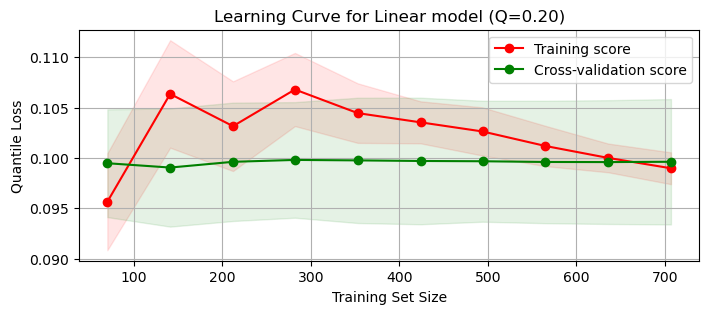

Cross-validated quantile loss: 0.0996 ± 0.0062
Quantile Loss on Train Set: 0.0991
Quantile Loss on Test Set: 0.1029




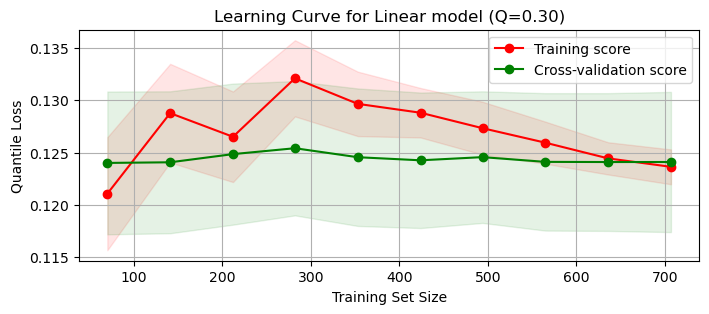

Cross-validated quantile loss: 0.1241 ± 0.0067
Quantile Loss on Train Set: 0.1237
Quantile Loss on Test Set: 0.1278




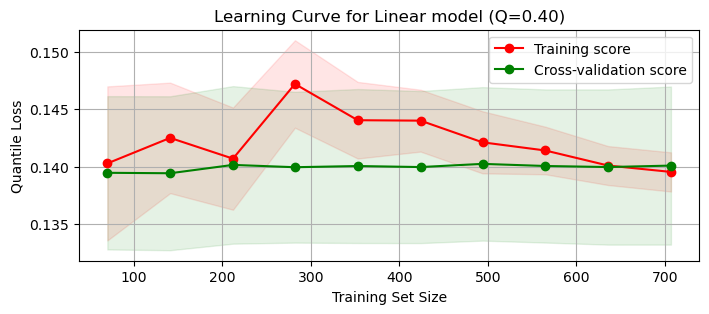

Cross-validated quantile loss: 0.1401 ± 0.0069
Quantile Loss on Train Set: 0.1396
Quantile Loss on Test Set: 0.1416




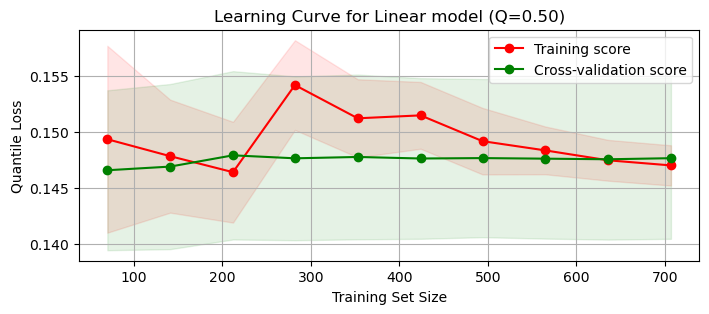

Cross-validated quantile loss: 0.1476 ± 0.0072
Quantile Loss on Train Set: 0.1470
Quantile Loss on Test Set: 0.1483




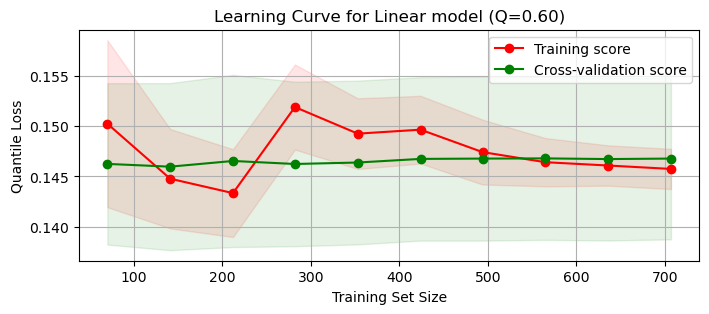

Cross-validated quantile loss: 0.1468 ± 0.0080
Quantile Loss on Train Set: 0.1458
Quantile Loss on Test Set: 0.1480




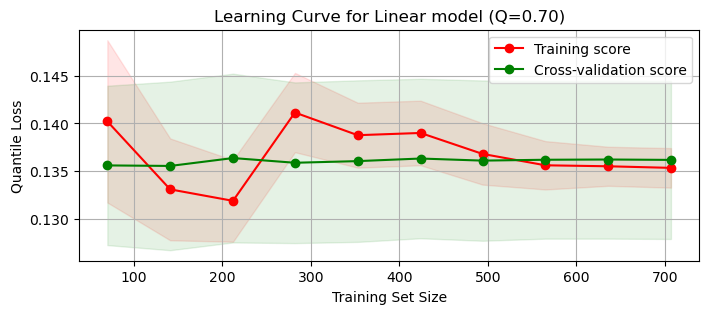

Cross-validated quantile loss: 0.1362 ± 0.0083
Quantile Loss on Train Set: 0.1354
Quantile Loss on Test Set: 0.1373




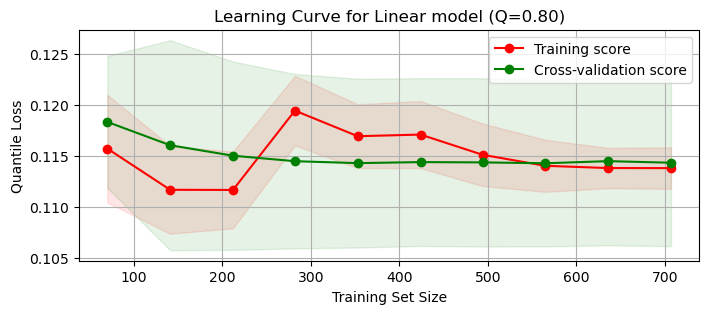

Cross-validated quantile loss: 0.1143 ± 0.0082
Quantile Loss on Train Set: 0.1138
Quantile Loss on Test Set: 0.1188




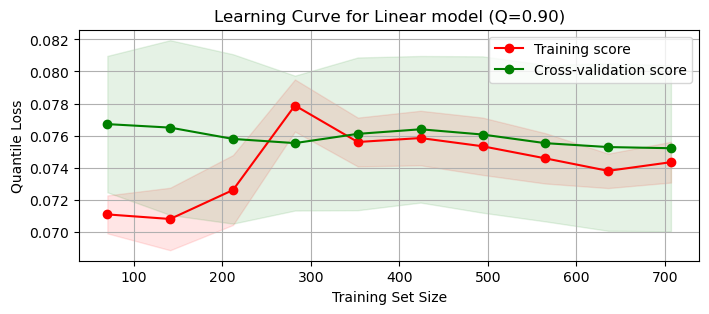

Cross-validated quantile loss: 0.0752 ± 0.0052
Quantile Loss on Train Set: 0.0744
Quantile Loss on Test Set: 0.0829




In [79]:
start_t = time.time()
models_lqr_det_depth, predictions_lqr_det_depth = store_ml_model_data('Linear model', 
                                                                      X_train_scaled_det_depth, 
                                                                      y_train_det_depth, 
                                                                      X_test_scaled_det_depth, 
                                                                      y_test_det_depth, 
                                                                      k_folds, 
                                                                      quantiles)
finish_t = time.time()

In [80]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 29.67s


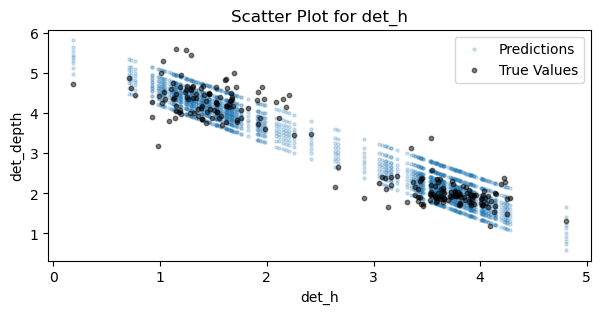

In [81]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_lqr_det_depth, quantiles, predictors_det_depth, targets[3])

#### Gradient boosted trees quantile regression

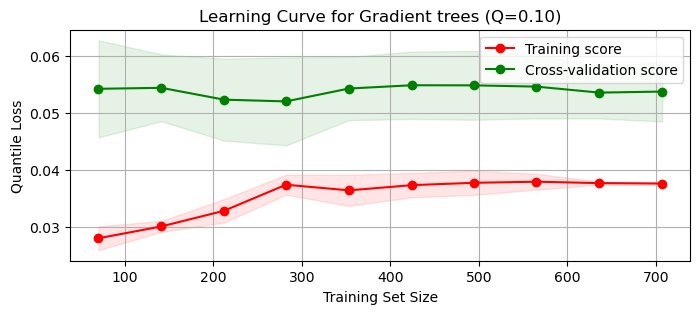

Cross-validated quantile loss: 0.0538 ± 0.0053
Quantile Loss on Train Set: 0.0381
Quantile Loss on Test Set: 0.0542




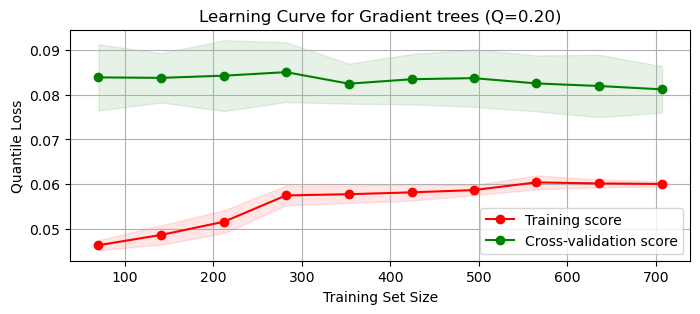

Cross-validated quantile loss: 0.0818 ± 0.0054
Quantile Loss on Train Set: 0.0620
Quantile Loss on Test Set: 0.0854




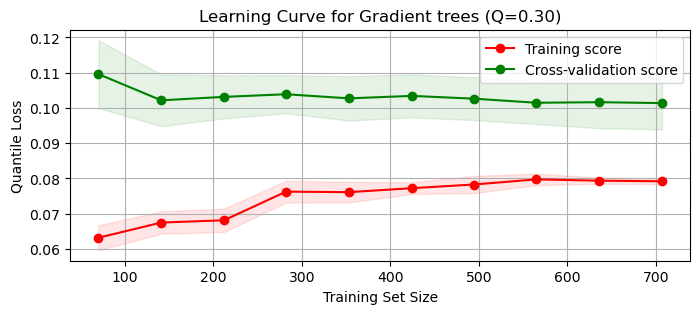

Cross-validated quantile loss: 0.1002 ± 0.0068
Quantile Loss on Train Set: 0.0810
Quantile Loss on Test Set: 0.1055




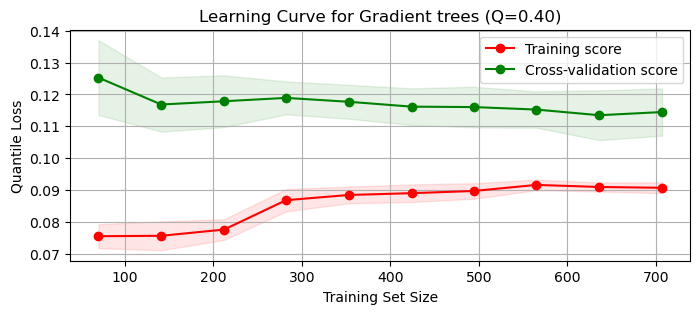

Cross-validated quantile loss: 0.1133 ± 0.0077
Quantile Loss on Train Set: 0.0928
Quantile Loss on Test Set: 0.1210




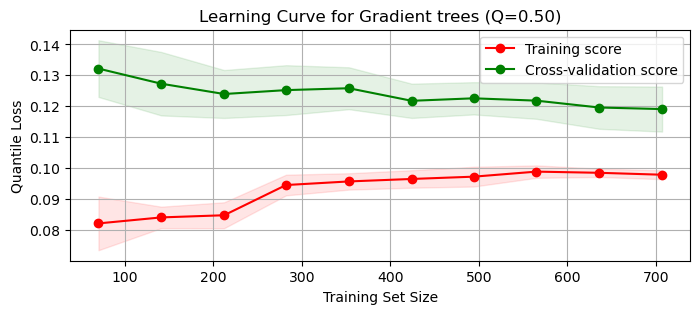

Cross-validated quantile loss: 0.1197 ± 0.0065
Quantile Loss on Train Set: 0.0995
Quantile Loss on Test Set: 0.1252




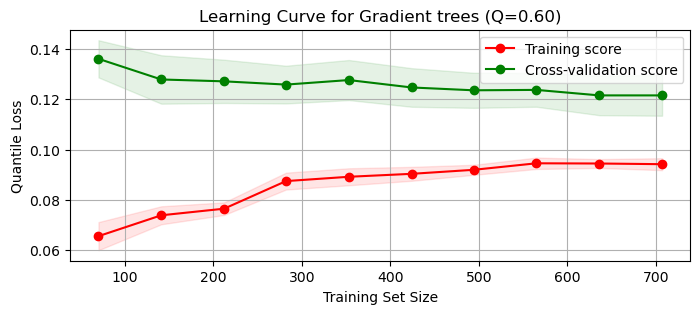

Cross-validated quantile loss: 0.1217 ± 0.0085
Quantile Loss on Train Set: 0.0960
Quantile Loss on Test Set: 0.1289




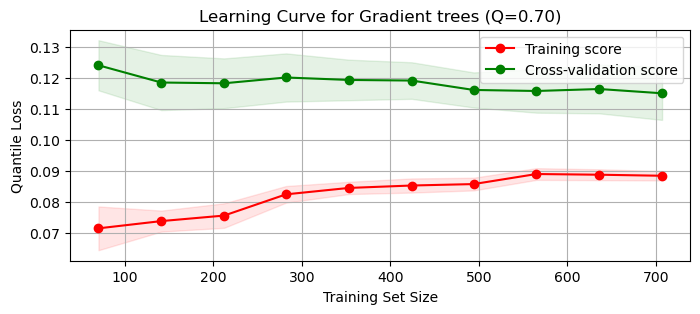

Cross-validated quantile loss: 0.1151 ± 0.0085
Quantile Loss on Train Set: 0.0901
Quantile Loss on Test Set: 0.1245




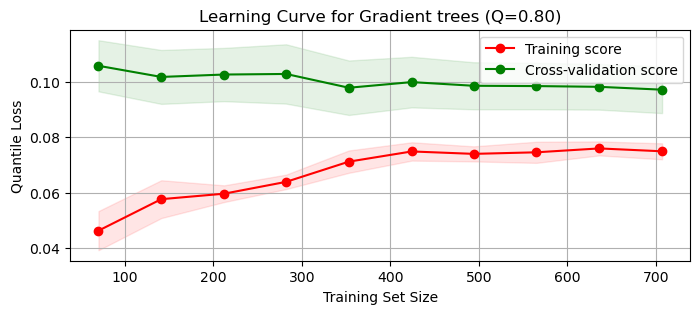

Cross-validated quantile loss: 0.0971 ± 0.0085
Quantile Loss on Train Set: 0.0788
Quantile Loss on Test Set: 0.0999




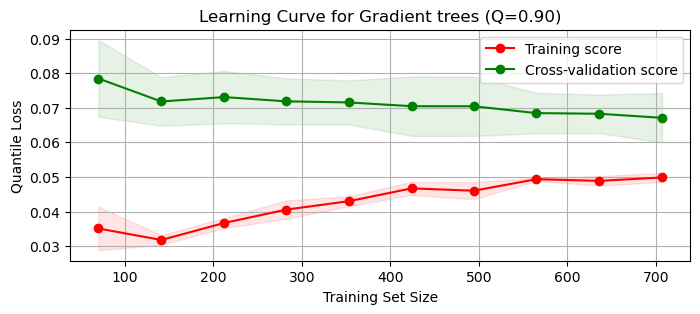

Cross-validated quantile loss: 0.0673 ± 0.0072
Quantile Loss on Train Set: 0.0515
Quantile Loss on Test Set: 0.0686




In [82]:
start_t = time.time()
models_gt_det_depth, predictions_gt_det_depth = store_ml_model_data('Gradient trees', 
                                                                    X_train_scaled_det_depth, 
                                                                    y_train_det_depth, 
                                                                    X_test_scaled_det_depth, 
                                                                    y_test_det_depth, 
                                                                    k_folds, 
                                                                    quantiles)
finish_t = time.time()

In [83]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 412.44s


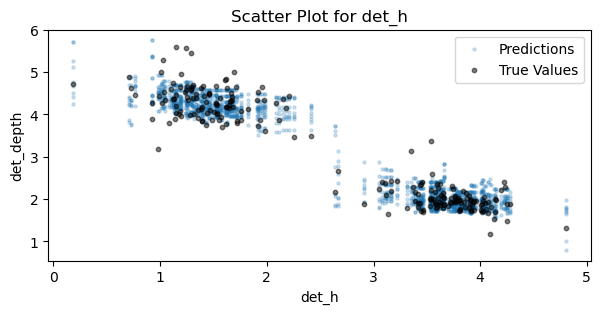

In [84]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_gt_det_depth, quantiles, predictors_det_depth, targets[3])

#### Histogram-based gradient trees quantile regression

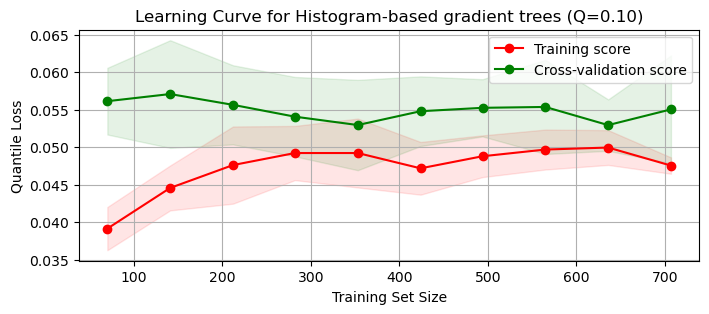

Cross-validated quantile loss: 0.0550 ± 0.0072
Quantile Loss on Train Set: 0.0510
Quantile Loss on Test Set: 0.0611




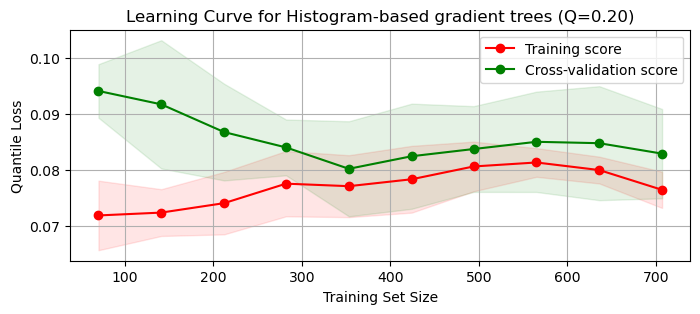

Cross-validated quantile loss: 0.0831 ± 0.0079
Quantile Loss on Train Set: 0.0832
Quantile Loss on Test Set: 0.0992




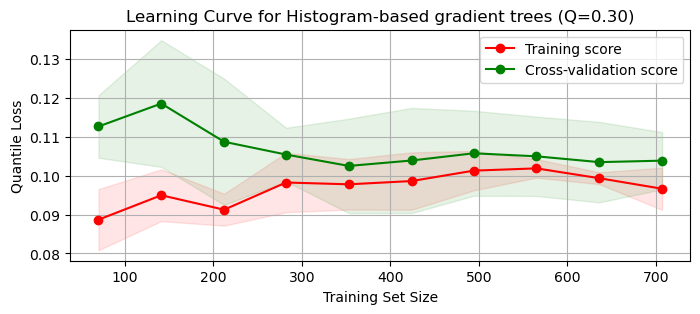

Cross-validated quantile loss: 0.1039 ± 0.0074
Quantile Loss on Train Set: 0.1018
Quantile Loss on Test Set: 0.1189




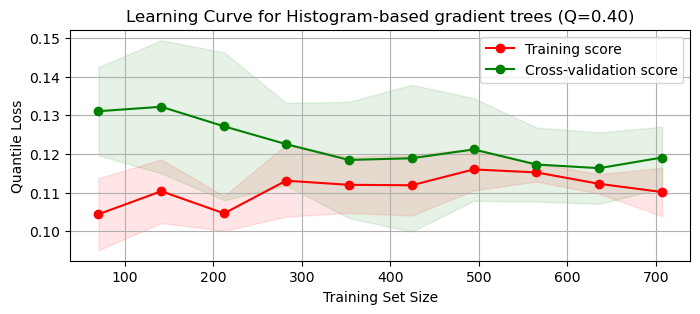

Cross-validated quantile loss: 0.1190 ± 0.0080
Quantile Loss on Train Set: 0.1132
Quantile Loss on Test Set: 0.1308




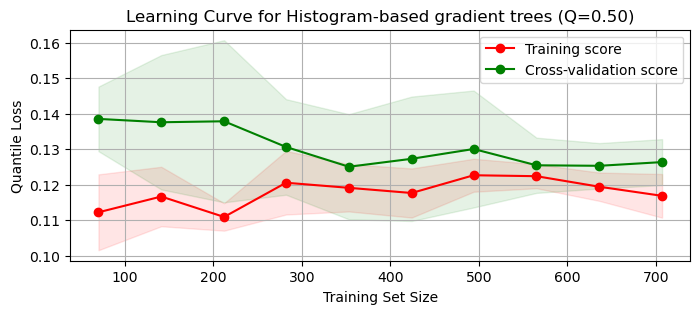

Cross-validated quantile loss: 0.1264 ± 0.0065
Quantile Loss on Train Set: 0.1190
Quantile Loss on Test Set: 0.1362




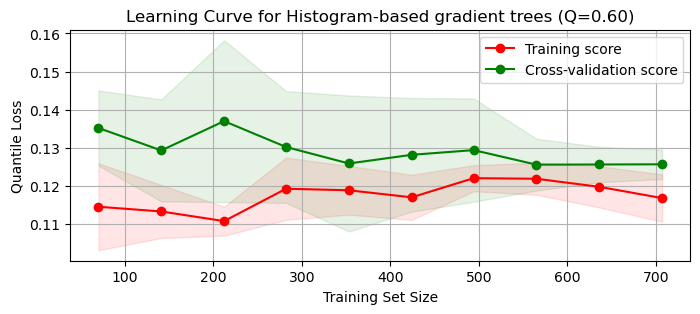

Cross-validated quantile loss: 0.1257 ± 0.0039
Quantile Loss on Train Set: 0.1173
Quantile Loss on Test Set: 0.1315




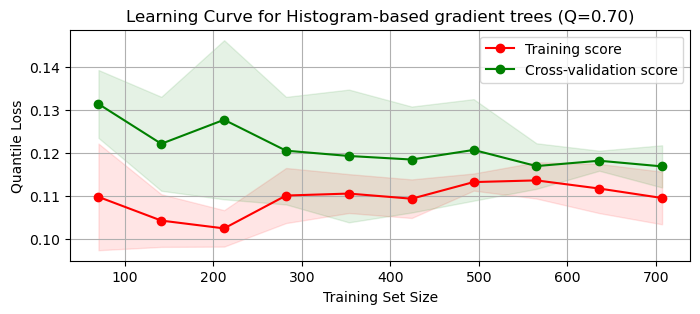

Cross-validated quantile loss: 0.1168 ± 0.0049
Quantile Loss on Train Set: 0.1085
Quantile Loss on Test Set: 0.1175




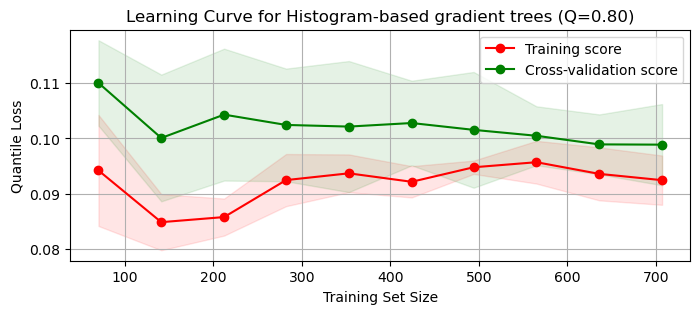

Cross-validated quantile loss: 0.0988 ± 0.0072
Quantile Loss on Train Set: 0.0914
Quantile Loss on Test Set: 0.0991




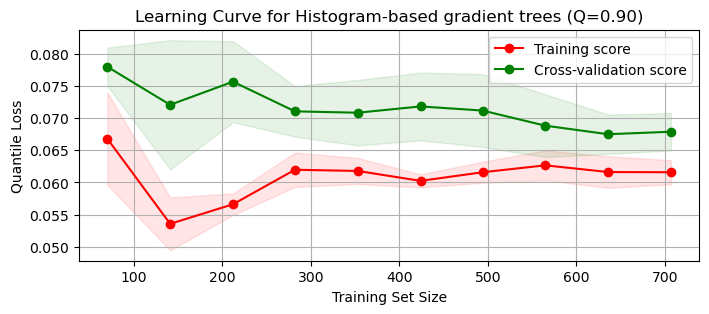

Cross-validated quantile loss: 0.0680 ± 0.0030
Quantile Loss on Train Set: 0.0612
Quantile Loss on Test Set: 0.0699




In [85]:
start_t = time.time()
models_hbgt_det_depth, predictions_hbgt_det_depth = store_ml_model_data('Histogram-based gradient trees', 
                                                                        X_train_scaled_det_depth, 
                                                                        y_train_det_depth, 
                                                                        X_test_scaled_det_depth, 
                                                                        y_test_det_depth, 
                                                                        k_folds, 
                                                                        quantiles)
finish_t = time.time()

In [86]:
print(f'Computational time: {(finish_t - start_t):.2f}s')

Computational time: 368.58s


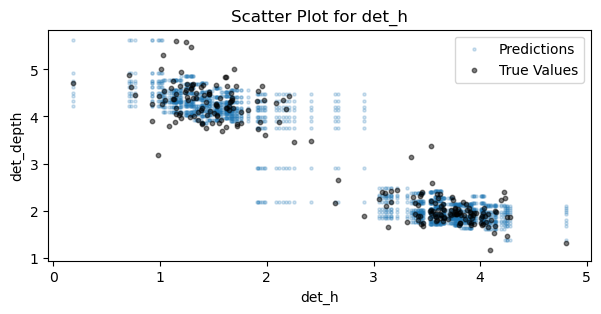

In [87]:
plot_predict_scatter(X_test_det_depth, y_test_det_depth, predictions_hbgt_det_depth, quantiles, predictors_det_depth, targets[3])

### Model comparison and practical evaluation

In roder to evaluate all models and determine their practilcal use, a function was defined which can plot the predicted conditional CDF of a target feature for an arbitrary set of conditions.

In [91]:
def plot_pred_cdf(index, pred_dict, target):
    y = []
    x_lqr = []
    x_gt = []
    x_hbgt = []

    plt.figure(figsize=(7, 4))
    for i in pred_dict['lqr'].keys():
        y.append(i)
        x_lqr.append(pred_dict['lqr'][i][index])
        x_gt.append(pred_dict['gt'][i][index])
        x_hbgt.append(pred_dict['hbgt'][i][index])
    plt.plot(x_lqr, y, color='tab:blue', label='Linear model')
    plt.plot(x_gt, y, color='tab:orange', label='Gradient trees')
    plt.plot(x_hbgt, y, color='tab:green', label='Histogram-based GT')
    plt.legend()
    plt.title('Predicted observation CDF')
    plt.ylabel('Cumulative Density')

An arbitrary sample index can be used to examine the level of agreement between all models and the quality of reproducing the conditional distribution of all predicted blast movement features.

In [92]:
sample_index = 123

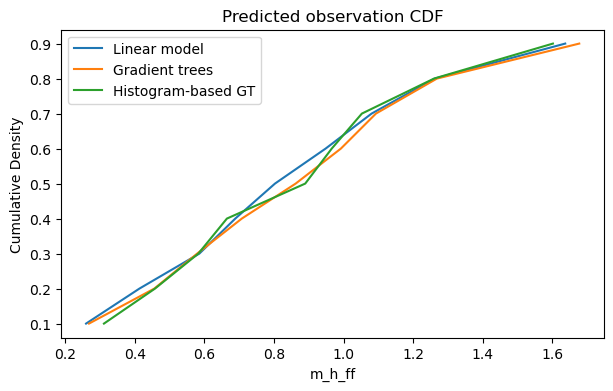

In [93]:
pred_dict_m_h_ff = {
    'lqr': predictions_lqr_m_h_ff,
    'gt': predictions_gt_m_h_ff,
    'hbgt': predictions_hbgt_m_h_ff,
}

plot_pred_cdf(sample_index, pred_dict_m_h_ff, 'm_h_ff')

plt.xlabel('m_h_ff')
plt.show()

The first results is very good. It shows a good agreement for all models for all parts of the CDF. The least amount of agreement is observed near the median, however, this is due to the larger quantile error in this region.

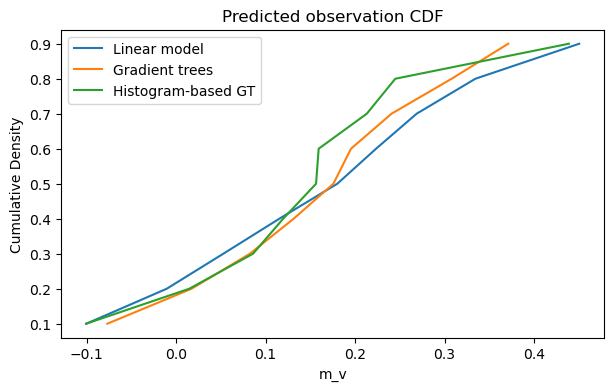

In [94]:
pred_dict_m_v = {
    'lqr': predictions_lqr_m_v,
    'gt': predictions_gt_m_v,
    'hbgt': predictions_hbgt_m_v,
}

plot_pred_cdf(sample_index, pred_dict_m_v, 'm_v')
plt.xlabel('m_v')
plt.show()

Alhough the Histogram-based regression model is quicker it fails to capture some peculiarities of the conditional distribution. Nonetheles, all models perform evidently well, including on the tails of the distribution.

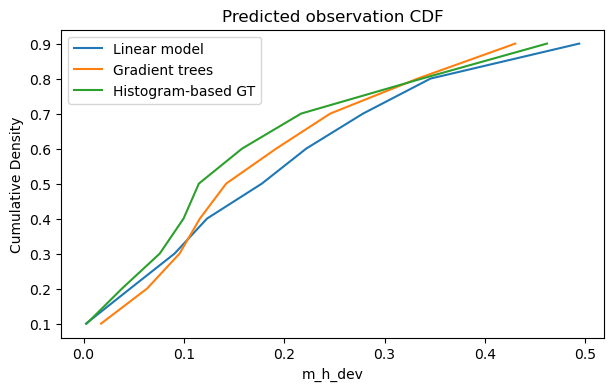

In [95]:
pred_dict_m_h_dev = {
    'lqr': predictions_lqr_m_h_dev,
    'gt': predictions_gt_m_h_dev,
    'hbgt': predictions_hbgt_m_h_dev,
}

plot_pred_cdf(sample_index, pred_dict_m_h_dev, 'm_h_dev')
plt.xlabel('m_h_dev')
plt.show()

It would seem that there is a good agreement for all models for this parameter. Moreover, the estimated CDF is not fully flat, which indicates a non-uniform behavor.

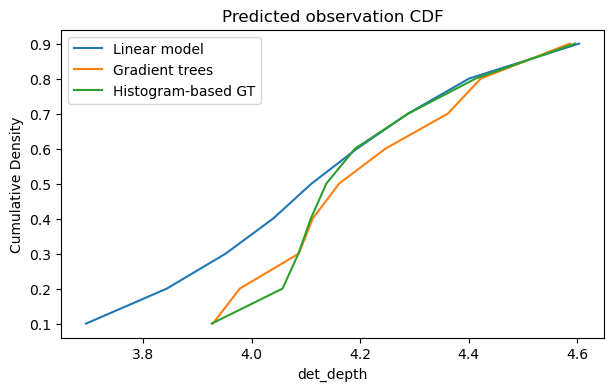

In [96]:
pred_dict_det_depth = {
    'lqr': predictions_lqr_det_depth,
    'gt': predictions_gt_det_depth,
    'hbgt': predictions_hbgt_det_depth,
}

plot_pred_cdf(sample_index, pred_dict_det_depth, 'det_depth')
plt.xlabel('det_depth')
plt.show()

Once, more the CDF function seems to be estimated well by all models, disregarding the potential addition of artifacts. However, the linear model seems to be more biased towards smaller values for the detection depth.

Check out Vol. 2.2. for a continuation of the code for training the model on each percentile and model deployment.